# Extracting parameters and plotting EMGs

In [2]:
import os
import numpy as np
import pandas as pd
import scipy.stats as spss
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
import arviz as az

plt.style.use("seaborn-ticks")

column_types={"time":"float16", #declaring types to go easy on RAM
              "conf":"int8",
              "average":"float32",
              "participant":"category",
              "expdResp":"category"
        }
epochPath = "../../data/EMG/Epochs_stim/"

In [115]:
raw_[raw_.time == 0]

p_right  SAT  time        epoch  rolling_L  rolling_R participant
2048       30  Acc   0.0  2399.744681   3.356409   2.551026      S7.csv
4404       30  Spd   0.0  1726.515957   5.222969   2.773848      S7.csv
6760       50  Acc   0.0  2332.346457   3.092358   2.656256      S7.csv
9116       50  Spd   0.0  1859.140909   3.304149   2.743504      S7.csv
11472      70  Acc   0.0  2243.527559   2.765024   2.927819      S7.csv
13828      70  Spd   0.0  1614.095890   3.087106   3.281428      S7.csv

In [36]:
raw_.loc[raw_.epoch == epoch, "Noncued_channel"]

615     -2.021041
616     -1.694837
617     -2.871213
618     -4.246299
619     -5.048014
          ...    
1225    -0.118458
1226     4.240337
1227     8.634523
1228    14.447851
1229    16.766312
Name: Noncued_channel, Length: 615, dtype: float64

In [43]:
epoch_dat[non_cued]

0      -5.008711
1      -5.833515
2      -4.810601
3      -2.445635
4       0.298428
         ...    
610    -1.170124
611    -4.380983
612    -8.028783
613   -11.595792
614    -7.473294
Name: EMG_R, Length: 615, dtype: float64

In [118]:
raw_.loc[(raw_.epoch == epoch) & (raw_.time == 0), "rolling_L"]

3854108    3.130866
Name: rolling_L, dtype: float64

In [13]:
epochPath = "../../data/EMG/Epochs_stim/"
list_dir = os.listdir(epochPath)
list_raw, list_parameters = [],[]
for f in list_dir:
    if 'partie 2' not in f.split('_')[0]:
        print(f.split('_')[0])
        raw_ = pd.read_table(epochPath+f, header=0, sep=',',skipinitialspace=True,
                     usecols=["epoch","time","condition","EMG_L","EMG_R"],
                     dtype=column_types)
        raw_['rolling_L'] = np.nan
        raw_['rolling_R'] = np.nan
        varL, varR = [],[]
        for epoch, epoch_dat in raw_.groupby('epoch'):
            rep = epoch_dat.condition.unique()[0].split('/')[1]
            raw_.loc[raw_.epoch == epoch, "rolling_L"] = epoch_dat["EMG_L"].rolling(int(.2*2048)).std()
            raw_.loc[raw_.epoch == epoch, "rolling_R"] = epoch_dat["EMG_R"].rolling(int(.2*2048)).std()
            rep = epoch_dat.condition.unique()[0].split('/')[2]
            varL.append(raw_.loc[(raw_.epoch == epoch) & (raw_.time == 0), "rolling_L"].values)
            varR.append(raw_.loc[(raw_.epoch == epoch) & (raw_.time == 0), "rolling_R"].values)

        del raw_['EMG_L']
        del raw_['EMG_R']
        raw_['SAT'], raw_['direction'], raw_['p_right'] = \
               zip(*raw_['condition'].map(lambda y: y.split('/')))
        del raw_['condition']
        raw_['participant'] = f.split('_')[0]
        raw_["direction"]= raw_.apply(lambda row: "right" if row['direction'] == "D" else "left", axis=1)
        raw_["valid"] = raw_.apply(lambda row : "valid" if row['direction'] == "right" and row['p_right'] == '70' else 
                           ("valid" if row['direction'] == "left" and row['p_right'] == '30' else 
                           ("even" if row['p_right'] == '50' else "invalid" )), axis = 1)
        #################### Extracting slope and baseline
        parameters = raw_.groupby(['epoch','SAT','p_right','direction']).mean().reset_index()
        parameters['varL'] = varL
        parameters['varR'] = varR
        parameters['participant'] = f.split('_')[0]
        list_parameters.append(parameters)
        #####################" Average time cours of participant"
        raw_ = raw_.groupby(['p_right','SAT','time']).mean()
        raw_ = raw_.reset_index()
        raw_['participant'] = f.split('_')[0]
        list_raw.append(raw_)

df_EMG_averages_tc = pd.concat(list_raw, ignore_index=True)
df_EMG_parameters = pd.concat(list_parameters, ignore_index=True)

df_EMG_parameters['SAT'] = df_EMG_parameters.SAT.replace(['Acc','Spd'], ['accuracy','speed'])
df_EMG_averages_tc['SAT'] = df_EMG_averages_tc.SAT.replace(['Acc','Spd'], ['accuracy','speed'])

df_EMG_averages_tc.to_csv("EMG_averages_tc_stimc_rolling.csv")
df_EMG_parameters.to_csv("EMG_baseline_rolling.csv")

S20.csv
S15.csv
S11.csv
S3.csv
S19.csv
S8.csv
S13.csv
S18.csv
S9.csv
S12.csv
S10.csv
S14.csv
S17.csv
S2.csv
S16.csv
S7.csv


In [111]:
df_EMG_parameters['SAT'] = df_EMG_parameters.SAT.replace(['Acc','Spd'], ['accuracy','speed'])
df_EMG_averages_tc['SAT'] = df_EMG_averages_tc.SAT.replace(['Acc','Spd'], ['accuracy','speed'])

df_EMG_averages_tc.to_csv("EMG_averages_tc_stimc_rolling.csv")
df_EMG_parameters.to_csv("EMG_baseline_rolling.csv")

In [90]:
df_EMG_averages_tc.to_csv("EMG_averages_tc_stimc_rolling.csv")


In [107]:
list_dir = os.listdir(epochPath)
list_raw, list_parameters = [],[]
for f in list_dir:
    if 'partie 2' not in f.split('_')[0]:
        print(f.split('_')[0])
        raw_ = pd.read_table(epochPath+f, header=0, sep=',',skipinitialspace=True,
                     usecols=["epoch","time","condition","EMG_L","EMG_R"],
                     dtype=column_types)
        baseline,ratio = [],[]
        for epoch, epoch_dat in raw_.groupby('epoch'):
            rep = epoch_dat.condition.unique()[0].split('/')[2]
            if rep == "70" :
                cued, non_cued = "EMG_R","EMG_L"
            elif rep == "30" : 
                cued, non_cued = "EMG_L","EMG_R"
            elif rep == "50" :
                cued = np.random.choice(['EMG_R','EMG_L'])
                if cued == "EMG_R":
                    non_cued = "EMG_L"
                else : 
                    non_cued = "EMG_R"
            raw_.loc[raw_.epoch == epoch, "Cued_channel"] = epoch_dat[cued]
            raw_.loc[raw_.epoch == epoch, "Noncued_channel"] = epoch_dat[non_cued]
            baseline.append(np.mean(raw_.loc[raw_.epoch == epoch, "Noncued_channel"][205:410])-np.mean(raw_.loc[raw_.epoch == epoch, "Cued_channel"][205:410]))# AUTOUR STIM de -50 à +50
            ratio.append(np.std(raw_.loc[raw_.epoch == epoch, "Cued_channel"][205:410])/np.var(raw_.loc[raw_.epoch == epoch, "Noncued_channel"][205:410]))# AUTOUR STIM de -50 à +50

        raw_['SAT'], raw_['direction'], raw_['p_right'] = \
               zip(*raw_['condition'].map(lambda y: y.split('/')))
        raw_['participant'] = f.split('_')[0]
        raw_["direction"]= raw_.apply(lambda row: "right" if row['direction'] == "D" else "left", axis=1)
        raw_["valid"] = raw_.apply(lambda row : "valid" if row['direction'] == "right" and row['p_right'] == '70' else 
                           ("valid" if row['direction'] == "left" and row['p_right'] == '30' else 
                           ("even" if row['p_right'] == '50' else "invalid" )), axis = 1)
        #################### Extracting slope and baseline
        parameters = raw_.groupby(['epoch','SAT','valid']).mean().reset_index()
        parameters['baseline'] = baseline
        parameters['ratio'] = ratio
        parameters['participant'] = f.split('_')[0]
        list_parameters.append(parameters)
        #####################" Average time cours of participant"
        #raw_ = raw_.groupby(['valid','SAT','time']).R_channel.mean()
        #raw_ = raw_.reset_index()
        #raw_['participant'] = f.split('_')[0]
        #list_raw.append(raw_)
    
#df_EMG_averages_tc = pd.concat(list_raw, ignore_index=True)
df_EMG_parameters = pd.concat(list_parameters, ignore_index=True)

#df_EMG_averages_tc = df_EMG_averages_tc[df_EMG_averages_tc.participant != "S12 partie 2.csv"]
#df_EMG_averages_tc = df_EMG_averages_tc[df_EMG_averages_tc.participant != "S10 partie 2.csv"]
#df_EMG_averages_tc = df_EMG_averages_tc[df_EMG_averages_tc.participant != "S14 partie 2.csv"]

df_EMG_parameters = df_EMG_parameters[df_EMG_parameters.participant != "S12 partie 2.csv"]
df_EMG_parameters = df_EMG_parameters[df_EMG_parameters.participant != "S10 partie 2.csv"]
df_EMG_parameters = df_EMG_parameters[df_EMG_parameters.participant != "S14 partie 2.csv"]

df_EMG_parameters['SAT'] = df_EMG_parameters.SAT.replace(['Acc','Spd'], ['accuracy','speed'])
df_EMG_parameters['Validity'] = df_EMG_parameters.valid
#df_EMG_averages_tc['SAT'] = df_EMG_averages_tc.SAT.replace(['Acc','Spd'], ['accuracy','speed'])
#df_EMG_averages_tc['Validity'] = df_EMG_averages_tc.valid

#df_EMG_averages_tc.to_csv("EMG_averages_tc_stimc.csv")
df_EMG_parameters.to_csv("EMG_baseline.csv")

S20.csv


KeyboardInterrupt: 

In [63]:
list_dir = os.listdir(epochPath)
list_raw, list_parameters = [],[]
for f in list_dir:
    if 'partie 2' not in f.split('_')[0]:
        print(f.split('_')[0])
        raw_ = pd.read_table(epochPath+f, header=0, sep=',',skipinitialspace=True,
                     usecols=["epoch","time","condition","EMG_L","EMG_R"],
                     dtype=column_types)
        meanL,meanR,varL,varR = [],[],[],[]
        for epoch, epoch_dat in raw_.groupby('epoch'):
            meanL.append(np.mean(epoch_dat.EMG_L[205:410]))# AUTOUR STIM de -50 à +50
            meanR.append(np.mean(epoch_dat.EMG_R[205:410]))
            varL.append(np.var(epoch_dat.EMG_L[205:410]))# AUTOUR STIM de -50 à +50
            varR.append(np.var(epoch_dat.EMG_R[205:410]))
        raw_['SAT'], raw_['direction'], raw_['p_right'] = \
               zip(*raw_['condition'].map(lambda y: y.split('/')))
        raw_['participant'] = f.split('_')[0]
        raw_["direction"]= raw_.apply(lambda row: "right" if row['direction'] == "D" else "left", axis=1)
        #################### Extracting slope and baseline
        parameters = raw_.groupby(['epoch','SAT','p_right','direction']).mean().reset_index()
        parameters['varL'] = varL
        parameters['varR'] = varR
        parameters['meanL'] = meanL
        parameters['meanR'] = meanR
        parameters['participant'] = f.split('_')[0]
        list_parameters.append(parameters)
        #####################" Average time cours of participant"
        #raw_ = raw_.groupby(['valid','SAT','time']).R_channel.mean()
        #raw_ = raw_.reset_index()
        #raw_['participant'] = f.split('_')[0]
        #list_raw.append(raw_)
    
#df_EMG_averages_tc = pd.concat(list_raw, ignore_index=True)
df_EMG_parameters = pd.concat(list_parameters, ignore_index=True)

#df_EMG_averages_tc = df_EMG_averages_tc[df_EMG_averages_tc.participant != "S12 partie 2.csv"]
#df_EMG_averages_tc = df_EMG_averages_tc[df_EMG_averages_tc.participant != "S10 partie 2.csv"]
#df_EMG_averages_tc = df_EMG_averages_tc[df_EMG_averages_tc.participant != "S14 partie 2.csv"]

df_EMG_parameters = df_EMG_parameters[df_EMG_parameters.participant != "S12 partie 2.csv"]
df_EMG_parameters = df_EMG_parameters[df_EMG_parameters.participant != "S10 partie 2.csv"]
df_EMG_parameters = df_EMG_parameters[df_EMG_parameters.participant != "S14 partie 2.csv"]

df_EMG_parameters['SAT'] = df_EMG_parameters.SAT.replace(['Acc','Spd'], ['accuracy','speed'])
#df_EMG_averages_tc['SAT'] = df_EMG_averages_tc.SAT.replace(['Acc','Spd'], ['accuracy','speed'])
#df_EMG_averages_tc['Validity'] = df_EMG_averages_tc.valid

#df_EMG_averages_tc.to_csv("EMG_averages_tc_stimc.csv")
df_EMG_parameters.to_csv("EMG_baseline.csv")

S20.csv
S15.csv
S11.csv
S3.csv
S19.csv
S8.csv
S13.csv
S18.csv
S9.csv
S12.csv
S10.csv
S14.csv
S17.csv
S2.csv
S16.csv
S7.csv


AttributeError: 'DataFrame' object has no attribute 'valid'

In [64]:

df_EMG_parameters.to_csv("EMG_baseline.csv")

Now also compute for errors !
quand == 50 on devrait faire EMGL - EMG R ?

In [3]:
df_EMG_averages_tc.to_csv("EMG_averages_tc_stimc.csv")
df_EMG_parameters.to_csv("EMG_baseline.csv")

In [135]:
df_EMG_parameters['SAT'] = df_EMG_parameters.SAT.replace(['Acc','Spd'], ['accuracy','speed'])
df_EMG_parameters['Validity'] = df_EMG_parameters.valid
df_EMG_averages_tc['SAT'] = df_EMG_averages_tc.SAT.replace(['Acc','Spd'], ['accuracy','speed'])
df_EMG_averages_tc['Validity'] = df_EMG_averages_tc.valid

df_EMG_averages_tc.to_csv("EMG_averages_stim.csv")
df_EMG_parameters.to_csv("EMG_parameters_stim.csv")

In [49]:
df_EMG_averages_tc = pd.read_csv("EMG_averages_tc_stimc.csv")
df_EMG_parameters = pd.read_csv("EMG_baseline.csv")

In [15]:
df_EMG_parameters.varL = [x[0] for x in df_EMG_parameters.varL]
df_EMG_parameters.varR = [x[0] for x in df_EMG_parameters.varR]

/home/gabriel/anaconda3/envs/pystan/lib/python3.8/site-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


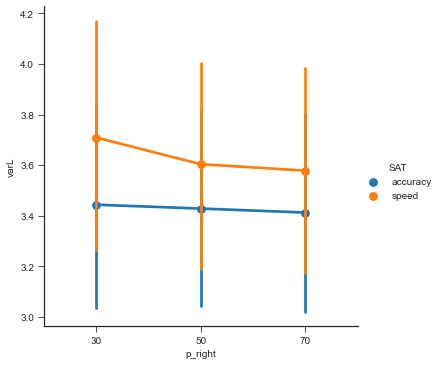

In [16]:
sns.factorplot(x="p_right",y="varL", hue="SAT",data = df_EMG_parameters[(np.abs(df_EMG_parameters.varL) < df_EMG_parameters.varL.std()*2)].groupby(['participant','p_right','SAT']).mean().reset_index())

/home/gabriel/anaconda3/envs/pystan/lib/python3.8/site-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


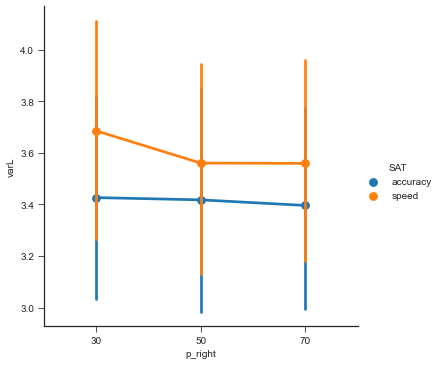

In [8]:
sns.factorplot(x="p_right",y="varL", hue="SAT",data = df_EMG_parameters[(np.abs(df_EMG_parameters.varL) < df_EMG_parameters.varL.std()*2)].groupby(['participant','p_right','SAT']).mean().reset_index())

/home/gabriel/anaconda3/envs/pystan/lib/python3.8/site-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


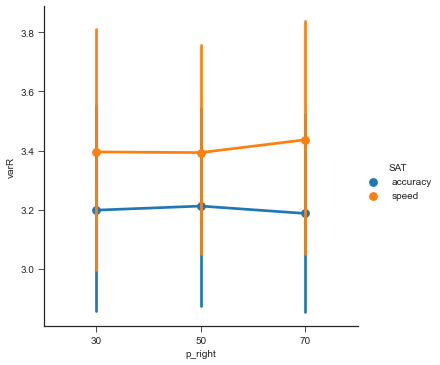

In [17]:
sns.factorplot(x="p_right",y="varR", hue="SAT",data = df_EMG_parameters[(np.abs(df_EMG_parameters.varR) < df_EMG_parameters.varR.std()*2)].groupby(['participant','p_right','SAT']).mean().reset_index())

<AxesSubplot:xlabel='varL', ylabel='Density'>

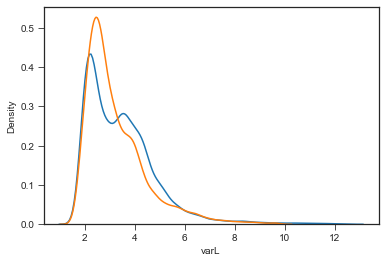

In [19]:
sns.kdeplot(df_EMG_parameters[(np.abs(df_EMG_parameters.varL) < df_EMG_parameters.varL.std()*2)].varL)
sns.kdeplot(df_EMG_parameters[(np.abs(df_EMG_parameters.varR) < df_EMG_parameters.varR.std()*2)].varR)


## Plotting mean time course of EMG

In [99]:
df_EMG_parameters['SAT'] = df_EMG_parameters.SAT.replace(['Acc','Spd'], ['Accuracy','Speed'])
df_EMG_parameters['Validity'] = df_EMG_parameters.valid.replace(['invalid','even','valid'], ['Invalid','Even','Valid'])
df_EMG_averages_tc['SAT'] = df_EMG_averages_tc.SAT.replace(['Acc','Spd'], ['Accuracy','Speed'])
df_EMG_averages_tc['Validity'] = df_EMG_averages_tc.valid.replace(['invalid','even','valid'], ['Invalid','Even','Valid'])

AttributeError: 'DataFrame' object has no attribute 'valid'

In [51]:
df_EMG_averages_tc['participant'] = df_EMG_averages_tc.participant.replace(df_EMG_averages_tc.participant.unique(), np.arange(len(df_EMG_averages_tc.participant.unique()))+1) 


In [17]:
print(df_EMG_parameters.participant.unique())
print(np.arange(len(df_EMG_parameters.participant.unique()))+1) 


['S20.csv' 'S15.csv' 'S11.csv' 'S3.csv' 'S19.csv' 'S8.csv' 'S13.csv'
 'S18.csv' 'S9.csv' 'S12.csv' 'S10.csv' 'S14.csv' 'S17.csv' 'S2.csv'
 'S16.csv' 'S7.csv']
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


Text(0.5, 0, 'Time from response EMG Onset (seconds)')

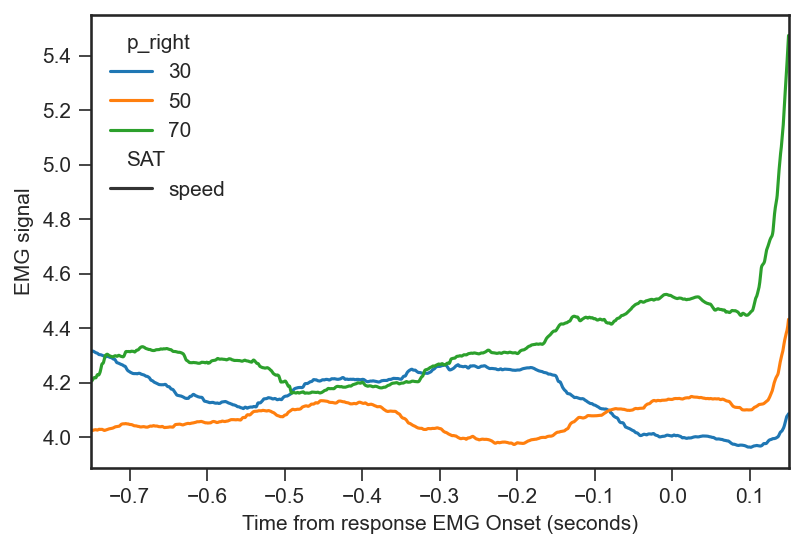

In [20]:
plt.figure(dpi=150)
grp_avrg = df_EMG_averages_tc[df_EMG_averages_tc.SAT == 'speed'].groupby(['time','p_right','SAT']).mean().reset_index()
sns.lineplot(data=grp_avrg, x='time', y="rolling_R", hue="p_right",ci=False, style="SAT")
plt.xlim(-.750, .150)
plt.ylabel('EMG signal')
plt.xlabel('Time from response EMG Onset (seconds)')

Text(0.5, 0, 'Time from response EMG Onset (seconds)')

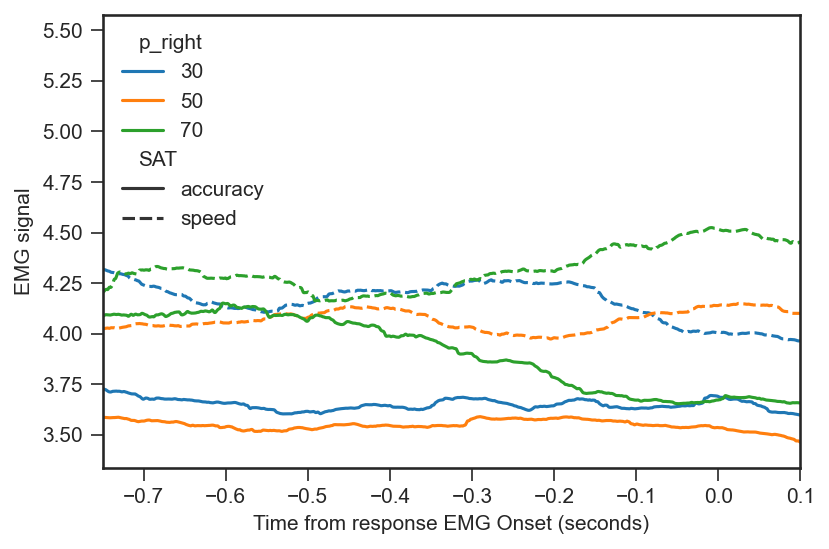

In [26]:
plt.figure(dpi=150)
grp_avrg = df_EMG_averages_tc.groupby(['time','p_right','SAT']).mean().reset_index()
sns.lineplot(data=grp_avrg, x='time', y="rolling_R", hue="p_right",ci=False, style="SAT")
plt.xlim(-.750, .10)
plt.ylabel('EMG signal')
plt.xlabel('Time from response EMG Onset (seconds)')

Text(0.5, 0, 'Time from response EMG Onset (seconds)')

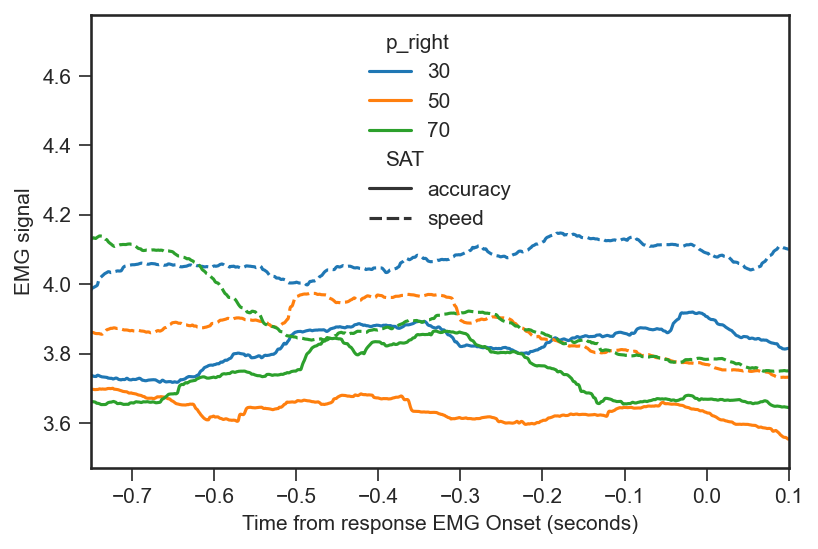

In [24]:
plt.figure(dpi=150)
grp_avrg = df_EMG_averages_tc.groupby(['time','p_right','SAT']).mean().reset_index()
sns.lineplot(data=grp_avrg, x='time', y="rolling_L", hue="p_right",ci=True, style="SAT")
plt.xlim(-.750, .10)
plt.ylabel('EMG signal')
plt.xlabel('Time from response EMG Onset (seconds)')

Text(0.5, 0, 'Time from response EMG Onset (seconds)')

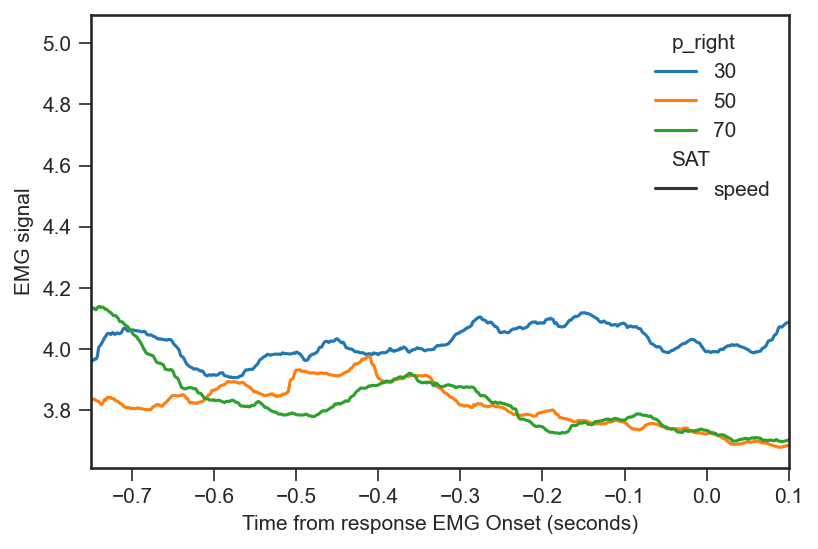

In [12]:
plt.figure(dpi=150)
grp_avrg = df_EMG_averages_tc[df_EMG_averages_tc.SAT == 'speed'].groupby(['time','p_right','SAT']).mean().reset_index()
sns.lineplot(data=grp_avrg, x='time', y="rolling_L", hue="p_right",ci=False, style="SAT")
plt.xlim(-.750, .10)
plt.ylabel('EMG signal')
plt.xlabel('Time from response EMG Onset (seconds)')

Text(0.5, 0, 'Time from response EMG Onset (seconds)')

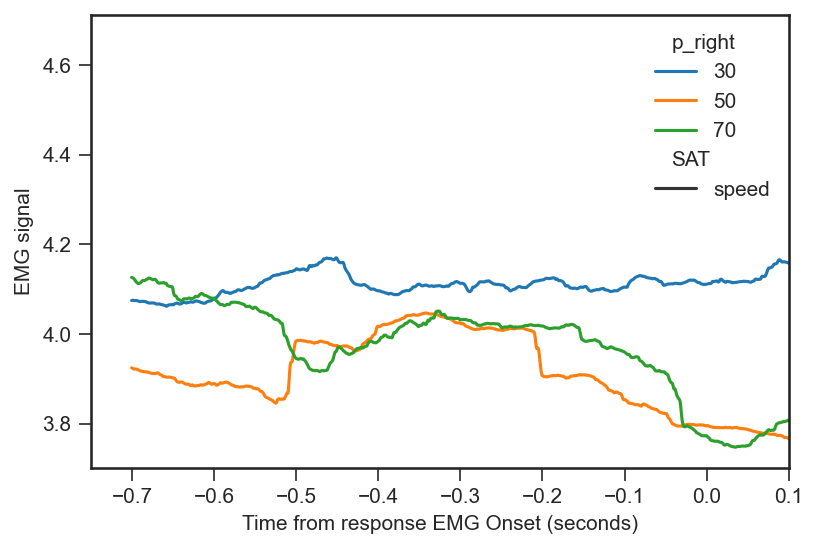

In [113]:
plt.figure(dpi=150)
grp_avrg = df_EMG_averages_tc[df_EMG_averages_tc.SAT == 'speed'].groupby(['time','p_right','SAT']).mean().reset_index()
sns.lineplot(data=grp_avrg, x='time', y="rolling_L", hue="p_right",ci=False, style="SAT")
plt.xlim(-.750, .10)
plt.ylabel('EMG signal')
plt.xlabel('Time from response EMG Onset (seconds)')

Text(0.5, 0, 'Time from response EMG Onset (seconds)')

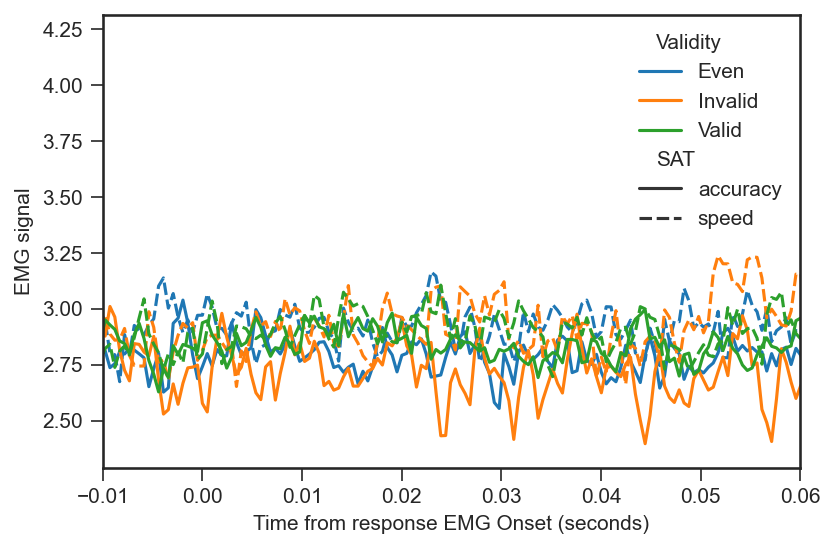

In [138]:
plt.figure(dpi=150)
grp_avrg = df_EMG_averages_tc.groupby(['time','Validity','SAT']).R_channel.median().reset_index()
sns.lineplot(data=grp_avrg, x='time', y="R_channel", hue="Validity",ci=False, style="SAT")
plt.xlim(-.010, .060)
plt.ylabel('EMG signal')
plt.xlabel('Time from response EMG Onset (seconds)')

Text(0.5, 0, 'Time from response EMG Onset (seconds)')

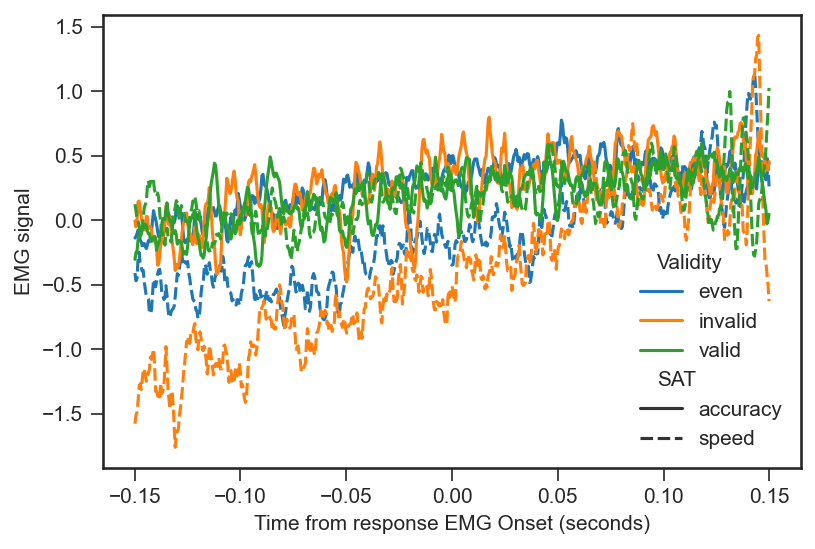

In [10]:
plt.figure(dpi=150)
grp_avrg = df_EMG_averages_tc.groupby(['time','Validity','SAT']).R_channel.mean().reset_index()
sns.lineplot(data=grp_avrg, x='time', y="R_channel", hue="Validity",ci=False, style="SAT", markers=False)

plt.ylabel('EMG signal')
plt.xlabel('Time from response EMG Onset (seconds)')

Text(0.5, 0, 'Time from response EMG Onset (seconds)')

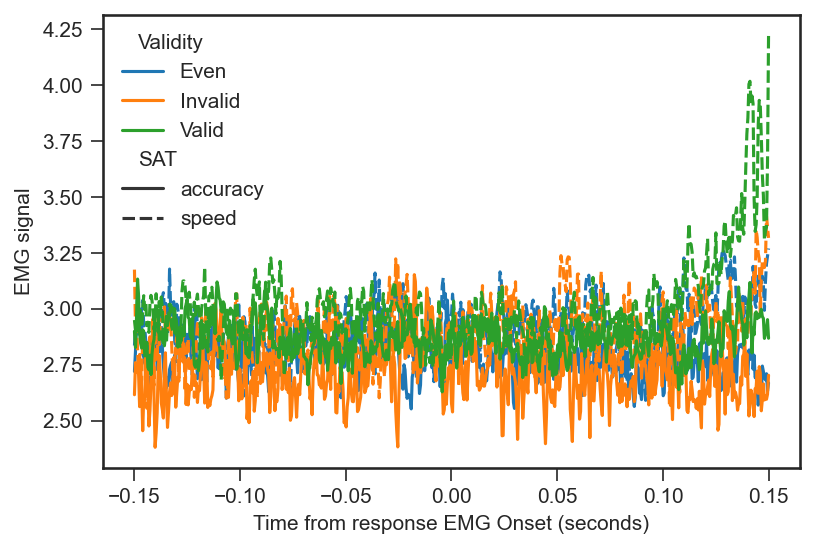

In [149]:
plt.figure(dpi=150)
grp_avrg = df_EMG_averages_tc.groupby(['time','Validity','SAT']).R_channel.median().reset_index()
sns.lineplot(data=grp_avrg, x='time', y="R_channel", hue="Validity",ci=False, style="SAT", markers=False)

plt.ylabel('EMG signal')
plt.xlabel('Time from response EMG Onset (seconds)')

## Fitting LMM on baseline 

In [150]:
LME = pystan.StanModel(file='MixedModels/LME.stan')
with open('MixedModels/LME.pkl', 'wb') as f:
    pickle.dump(LME, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_591d5b33c7aabcc814ddc6bdd9dfa2a6 NOW.


In [3]:
LMEdata = df_EMG_parameters.copy()
LMEdata = LMEdata[(np.abs(LMEdata.baseline) < 2*(LMEdata.baseline.std()))]
print(LMEdata.head())
LMEdata['SAT'] = LMEdata.apply(lambda row: 0 if row['SAT'] == "speed" else 1, axis=1)
LMEdata['Validity'] = LMEdata.apply(lambda row: -0.5 if row['valid'] == "invalid" else (
	0.5 if row['valid'] == 'valid' else 0), axis=1)
LMEdata['participant'] = LMEdata.participant.replace(LMEdata.participant.unique(), np.arange(len(LMEdata.participant.unique()))+1) 
LMEdata = LMEdata[["baseline","participant",
                   "SAT","Validity"]]
print(LMEdata.head())


   Unnamed: 0  epoch       SAT    valid  time  R_channel  baseline  \
0           0      0  accuracy     even   0.0   3.419003  3.604695   
1           1      3  accuracy  invalid   0.0   4.980282  5.824573   
2           2      6  accuracy    valid   0.0   3.242302  3.450122   
3           3      9  accuracy     even   0.0   3.623159  4.198200   
4           4     12  accuracy    valid   0.0   3.712823  3.680451   

  participant Validity  
0     S20.csv     even  
1     S20.csv  invalid  
2     S20.csv    valid  
3     S20.csv     even  
4     S20.csv    valid  
   baseline  participant  SAT  Validity
0  3.604695            1    1       0.0
1  5.824573            1    1      -0.5
2  3.450122            1    1       0.5
3  4.198200            1    1       0.0
4  3.680451            1    1       0.5


23.367603997488647


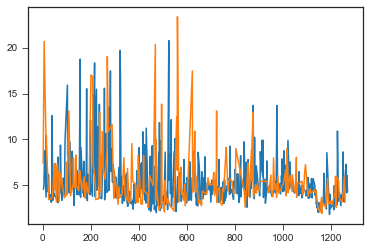

22.124982888932404


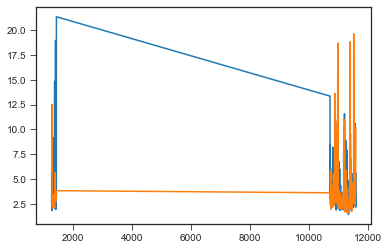

22.55169156325311


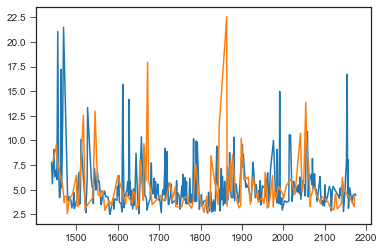

24.225629861004833


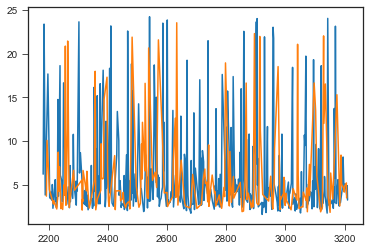

24.165415881067414


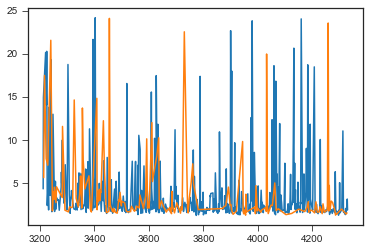

24.123319997050935


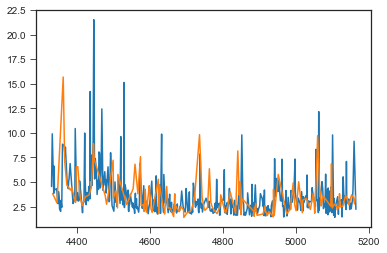

23.89900641844833


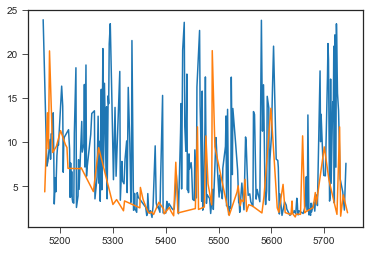

23.345409266759585


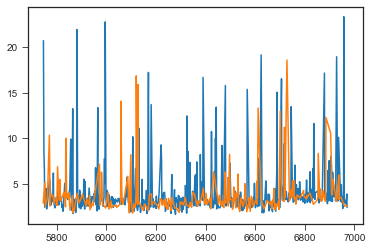

24.242466441585695


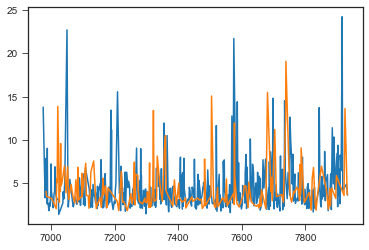

23.31066427215228


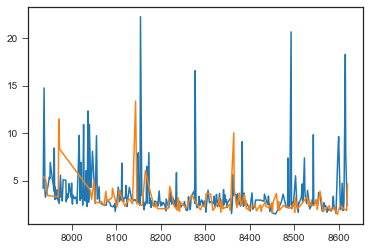

24.279083345626532


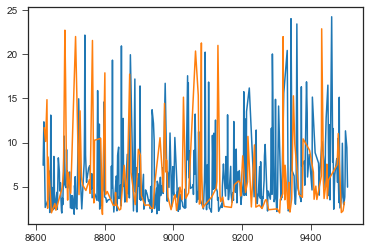

24.15417832336209


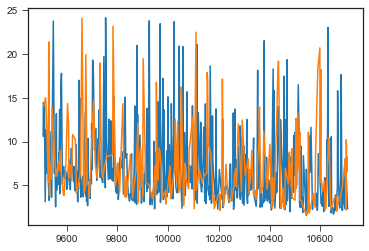

24.09028776267186


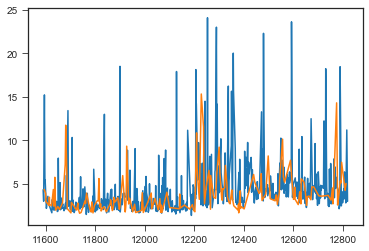

24.15172547328362


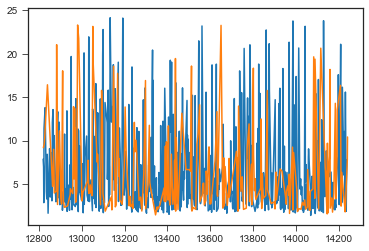

24.223992615543786


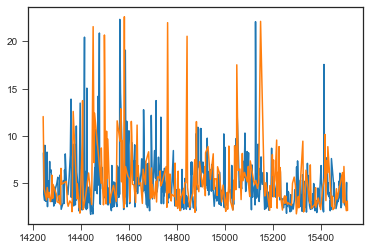

22.49120729865608


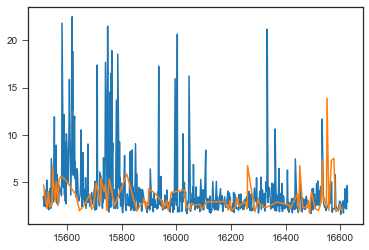

In [109]:
for part in np.arange(16)+1: 
    LMEdata.baseline[(LMEdata.participant == part) & (LMEdata.Validity == 0.5)].plot()
    LMEdata.baseline[(LMEdata.participant == part) & (LMEdata.Validity == -0.5)].plot()
    print(LMEdata.baseline[(LMEdata.participant == part)].max())
    plt.show()
    

# SHOULD TRY BY TAKING THE BASELIN NOT IN ABS !

In [ ]:
import pickle
import patsy
LME = pickle.load(open('MixedModels/LME.pkl', 'rb'))

model_name = "baseline_stim_fit"

fixeff_form = "1+SAT+Validity+SAT:Validity"#Fixed effects formula
raneff_form = fixeff_form #Random effects formula
fixeff = np.asarray(patsy.dmatrix(fixeff_form, LMEdata)) #FE design matrix
raneff = np.asarray(patsy.dmatrix(raneff_form, LMEdata)) #RE design matrix
prior_intercept = np.asarray([4,10])#prior for intercept, mu and sigma
priors_mu = np.repeat(0, 3) #Priors on mu for FE
priors_sigma =  np.repeat(10, 3) # priors on sigma for FE
priors_raneff = [0, 10] #Priors on RE
prior_sd = [0, 10] #priors on residual sigma

LME_data = dict(
    N = len(LMEdata),
    P = fixeff.shape[-1], #number of pop level effects
    J = len(LMEdata.participant.unique()),
    n_u = raneff.shape[-1],
    subj = LMEdata.participant,
    X = fixeff,
    Z_u = raneff,
    y = LMEdata.baseline.values,
    p_intercept = prior_intercept, p_sd = prior_sd, p_fmu = priors_mu, p_fsigma = priors_sigma, p_r = priors_raneff,
    logT = 0
)

if os.path.exists("MixedModels/FittedModels/%s.pkl"%model_name):
    with open("MixedModels/FittedModels/%s.pkl"%model_name, "rb") as f:
        data_dict = pickle.load(f)
    fit = data_dict['fit']

else:
    fit = LME.sampling(data=LME_data, iter=2000, chains=6, n_jobs=6, 
                              warmup = 1000,thin=2)
    with open("MixedModels/FittedModels/%s.pkl"%model_name, "wb") as f:
        pickle.dump({'model' : LME, 'fit' : fit}, f, protocol=-1)

baseline_fit_az = az.from_pystan(posterior=fit, posterior_predictive='y_hat', observed_data="y", log_likelihood='log_lik',
                                       coords={'b': fixeff_form.split('+')[1:]}, dims={'beta': ['b']})

/home/gabriel/anaconda3/envs/pystan/lib/python3.8/site-packages/arviz/utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(


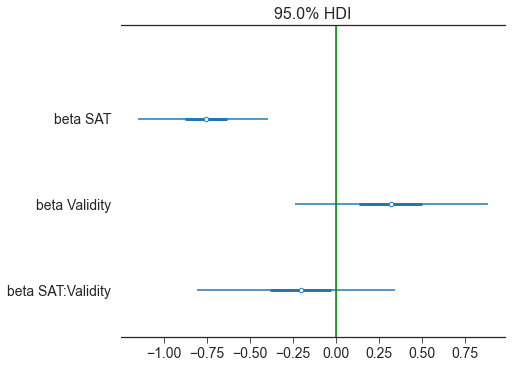

In [44]:
g = az.plot_forest(baseline_fit_az, var_names="beta", credible_interval=0.95, 
                   combined=True, figsize=(7,5), rope=(0,0))
plt.vlines(0, -1, 10, 'g')
plt.show()


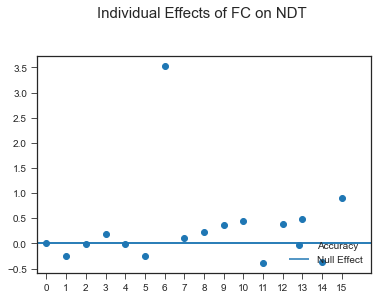

In [63]:
#fir, ax = plt.subplots(1,2, figsize=(14,4), sharey=True)
mean_Validity = baseline_fit_az.posterior.beta.sel(b="Validity").mean(axis=(0,1)).values 
indiv_Validity = mean_Validity + baseline_fit_az.posterior.u.sel(u_dim_1=2).mean(axis=(0,1)).values

plt.plot(indiv_Validity,'o', label="Accuracy")
#plt.plot(16,ter_fit.posterior.beta.sel(b="FC").mean(axis=(0,1)), 'o', label="mean", color="b", markersize=10)
plt.hlines(0, -1, 17)
#meanSATFC = ter_fit.posterior.beta.sel(b="SAT:FC").mean(axis=(0,1)).values
#indivSATFC = meanSATFC + ter_fit.posterior.u.sel(u_dim_1=4).mean(axis=(0,1)).values
plt.hlines(0, -1, 17,label="Null Effect")
plt.xlim(-0.5,16.5)
plt.xticks(np.linspace(0,15,16))
plt.title('Individual Effects of FC on NDT \n\n', fontsize=15)
plt.legend(loc=4)
plt.show()

/home/gabriel/anaconda3/envs/pystan/lib/python3.8/site-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


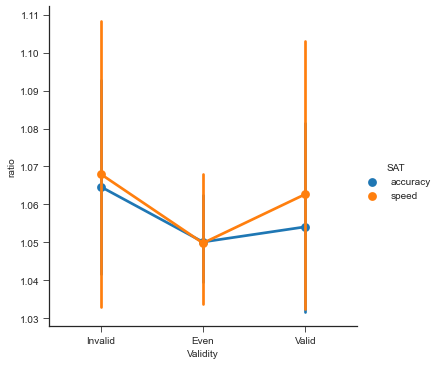

In [56]:
sns.factorplot(x="Validity",y="ratio", hue="SAT",data = df_EMG_parameters[(np.abs(df_EMG_parameters.ratio) < df_EMG_parameters.ratio.std()*2)].groupby(['participant','Validity','SAT']).mean().reset_index(),order=['Invalid','Even','Valid'])

/home/gabriel/anaconda3/envs/pystan/lib/python3.8/site-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


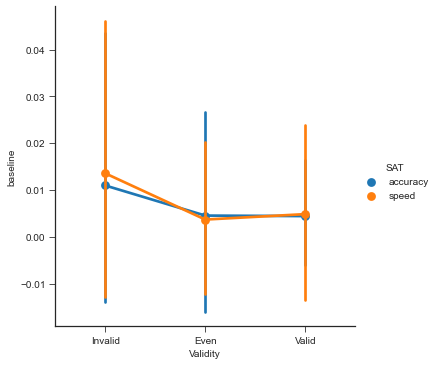

In [57]:
sns.factorplot(x="Validity",y="baseline", hue="SAT",data = df_EMG_parameters[(np.abs(df_EMG_parameters.ratio) < df_EMG_parameters.ratio.std()*2)].groupby(['participant','Validity','SAT']).mean().reset_index(),order=['Invalid','Even','Valid'])

<AxesSubplot:xlabel='baseline', ylabel='Density'>

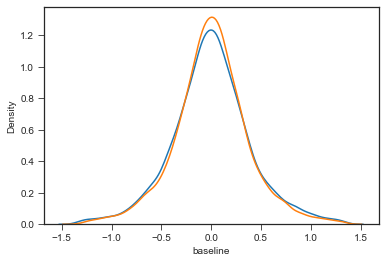

In [55]:
sns.kdeplot(df_EMG_parameters[(np.abs(df_EMG_parameters.baseline) < df_EMG_parameters.baseline.std()*2)&(df_EMG_parameters.SAT == "speed")].baseline)
sns.kdeplot(df_EMG_parameters[(np.abs(df_EMG_parameters.baseline) < df_EMG_parameters.baseline.std()*2)&(df_EMG_parameters.SAT == "accuracy")].baseline)


<AxesSubplot:xlabel='ratio', ylabel='Density'>

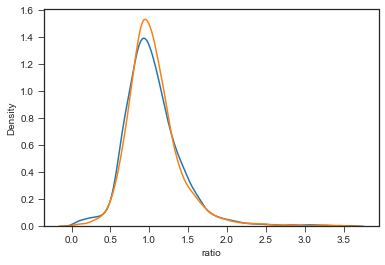

In [58]:
sns.kdeplot(df_EMG_parameters[(np.abs(df_EMG_parameters.ratio) < df_EMG_parameters.ratio.std()*2)&(df_EMG_parameters.SAT == "speed")].ratio)
sns.kdeplot(df_EMG_parameters[(np.abs(df_EMG_parameters.ratio) < df_EMG_parameters.ratio.std()*2)&(df_EMG_parameters.SAT == "accuracy")].ratio)


In [52]:
df_EMG_parameters.ratio

0        0.955188
1        2.502597
2        0.877653
3        0.985584
4        0.725824
           ...   
19278    1.501193
19279    1.636540
19280    0.762614
19281    1.554817
19282    1.730388
Name: ratio, Length: 19283, dtype: float64

<AxesSubplot:>

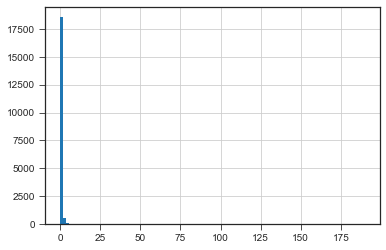

In [53]:
df_EMG_parameters.ratio.hist(bins=100)

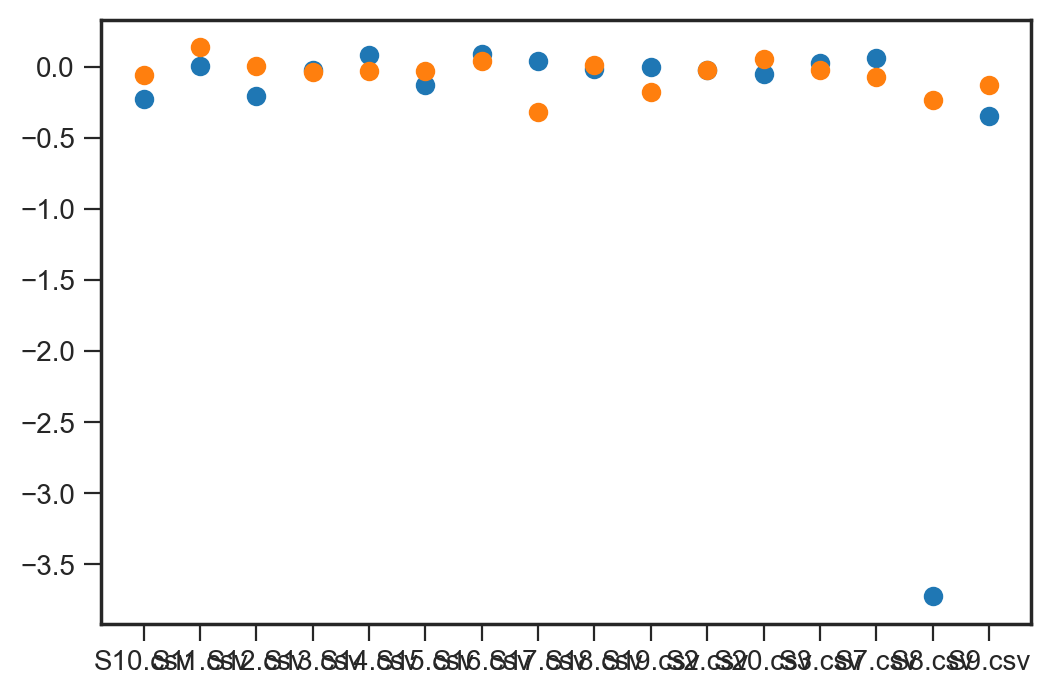

In [145]:
#for part in np.arange(16)+1:
plt.figure(dpi=200)
diff = df_EMG_parameters[(df_EMG_parameters.Validity == "Invalid") & (df_EMG_parameters.SAT == "speed")].groupby('participant').baseline.median() - df_EMG_parameters[(df_EMG_parameters.Validity == "Valid")  & (df_EMG_parameters.SAT == "speed")].groupby('participant').baseline.median()
plt.plot(diff,'o')
diff = df_EMG_parameters[(df_EMG_parameters.Validity == "Invalid") & (df_EMG_parameters.SAT == "accuracy")].groupby('participant').baseline.median() - df_EMG_parameters[(df_EMG_parameters.Validity == "Valid")  & (df_EMG_parameters.SAT == "accuracy")].groupby('participant').baseline.median()
plt.plot(diff,'o')

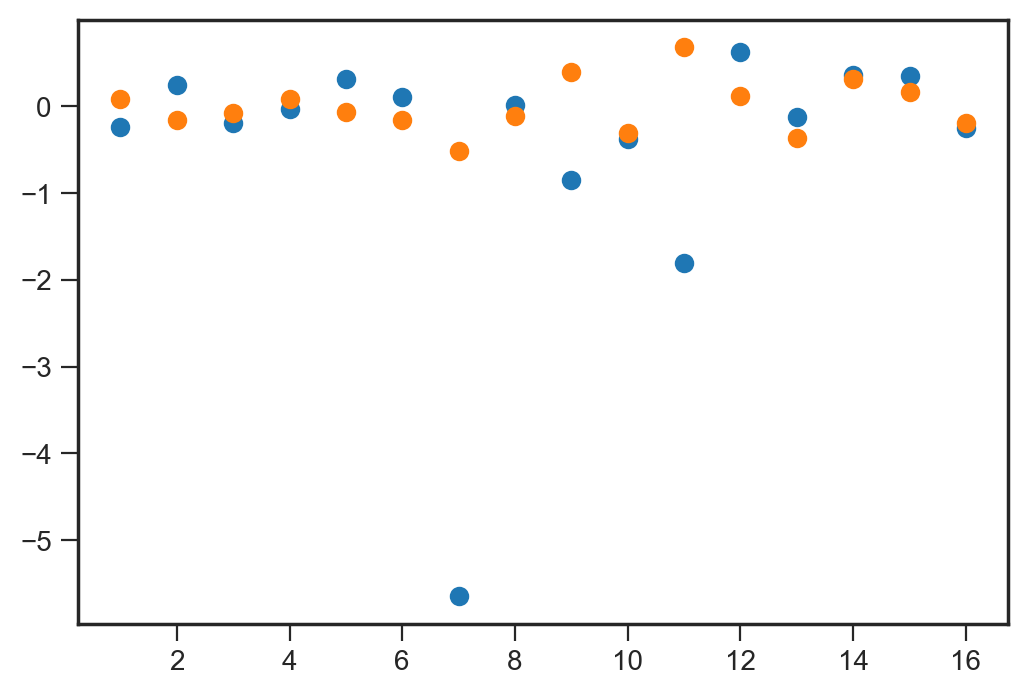

In [126]:
#for part in np.arange(16)+1:
plt.figure(dpi=200)
diff = df_EMG_parameters[(df_EMG_parameters.Validity == "Invalid") & (df_EMG_parameters.SAT == "speed")].groupby('participant').baseline.median() - df_EMG_parameters[(df_EMG_parameters.Validity == "Valid")  & (df_EMG_parameters.SAT == "speed")].groupby('participant').baseline.median()
plt.plot(diff,'o')
diff = df_EMG_parameters[(df_EMG_parameters.Validity == "Invalid") & (df_EMG_parameters.SAT == "accuracy")].groupby('participant').baseline.median() - df_EMG_parameters[(df_EMG_parameters.Validity == "Valid")  & (df_EMG_parameters.SAT == "accuracy")].groupby('participant').baseline.median()
plt.plot(diff,'o')

In [131]:
df_EMG_parameters['logbase'] = np.log(df_EMG_parameters['baseline'])

/home/gabriel/anaconda3/envs/pystan/lib/python3.8/site-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


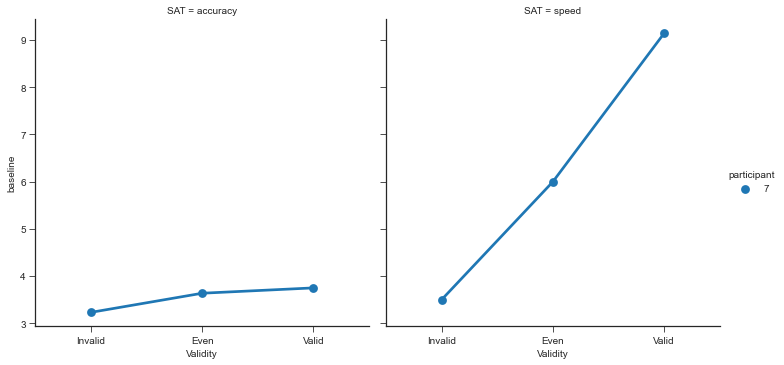

In [58]:
sns.factorplot(x="Validity",y="baseline", hue="participant", col="SAT",data = df_EMG_parameters[df_EMG_parameters.participant == 7].groupby(['participant','Validity','SAT']).median().reset_index(),order=['Invalid','Even','Valid'])

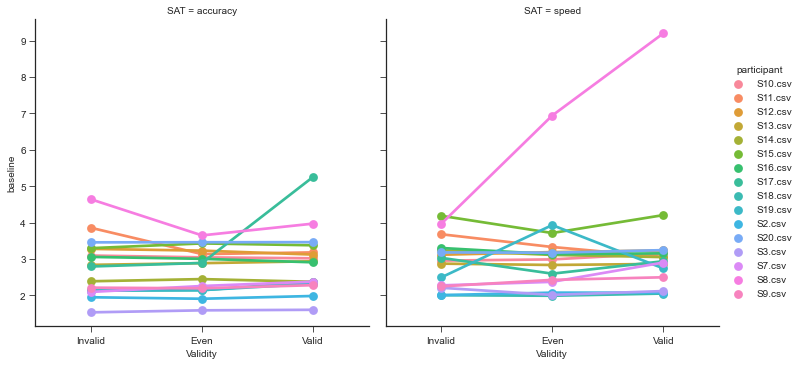

In [147]:
sns.factorplot(x="Validity",y="baseline", hue="participant", col="SAT",data = df_EMG_parameters.groupby(['participant','Validity','SAT']).mean().reset_index(),order=['Invalid','Even','Valid'])

KeyboardInterrupt: 

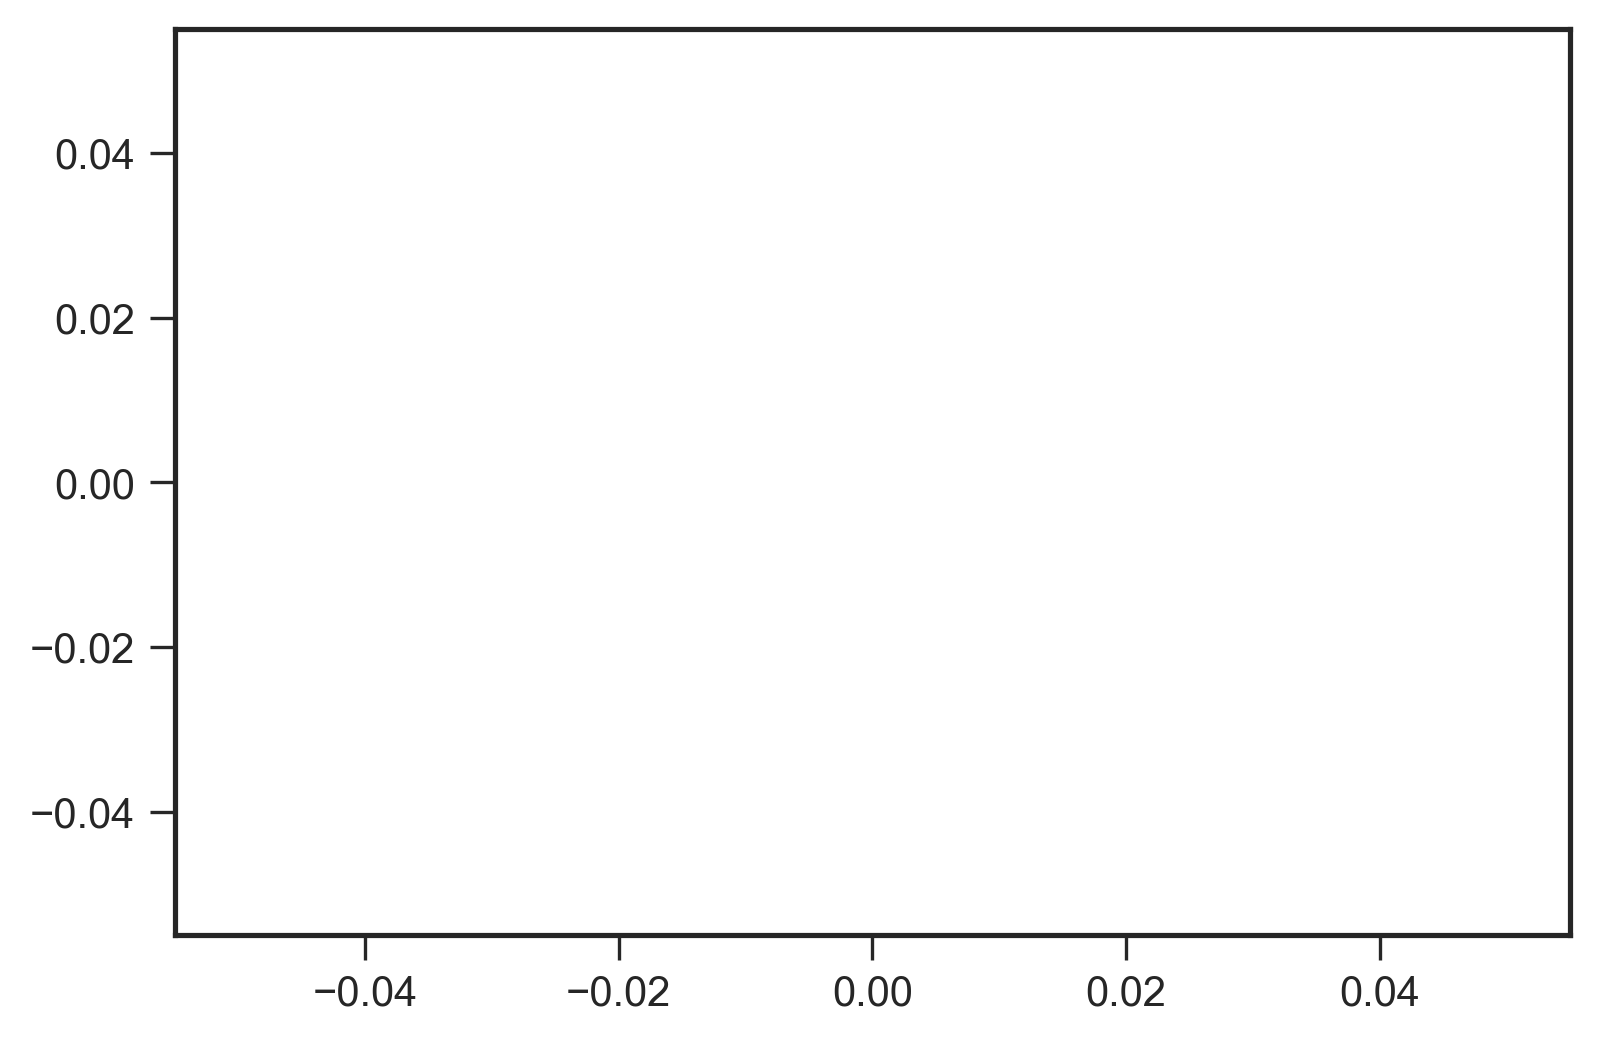

In [21]:
plt.figure(dpi=300)
grp_avrg = df_EMG_averages_tc.groupby(['participant','time','Validity','SAT']).R_channel.mean().reset_index()
sns.lineplot(data=grp_avrg, x='time', y="R_channel", hue="Validity",ci=False, style="SAT")
plt.xlim(-.010, .060)
plt.ylabel('EMG signal')
plt.xlabel('Time from response EMG Onset (seconds)')

Text(0.5, 0, 'Time from response EMG Onset (seconds)')

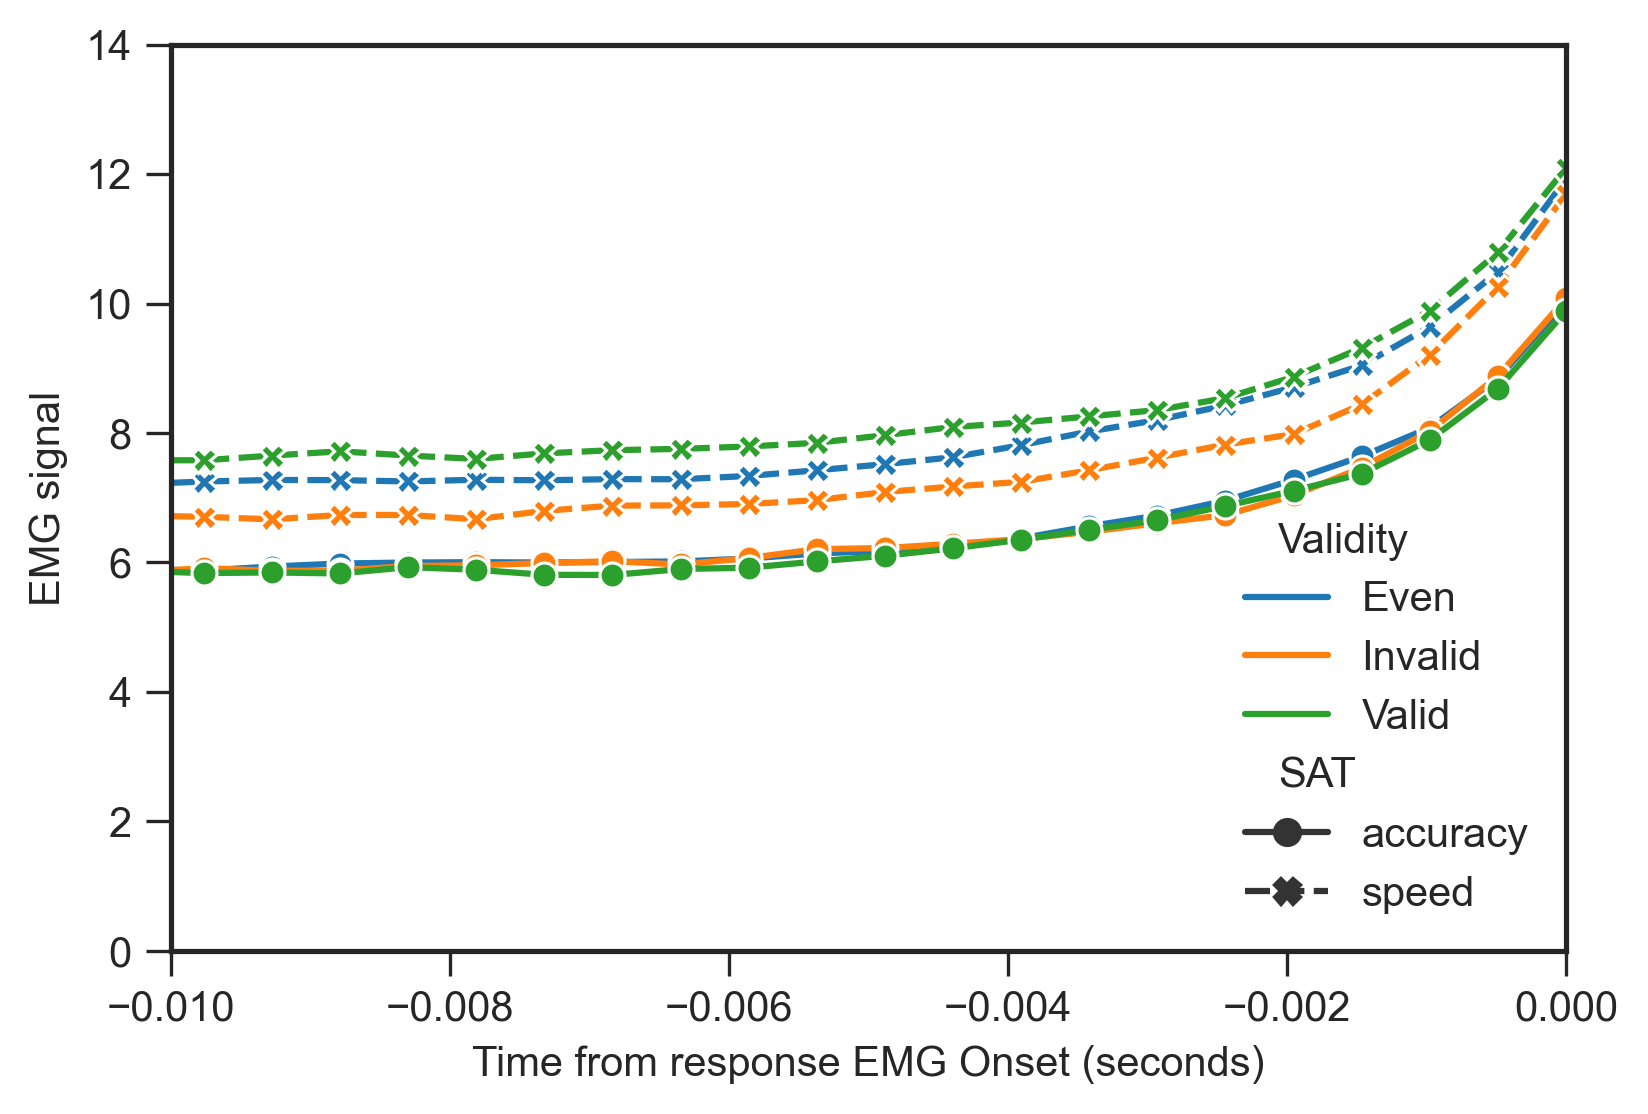

In [5]:
plt.figure(dpi=300)
grp_avrg = df_EMG_averages_tc.groupby(['time','Validity','SAT']).R_channel.mean().reset_index()
sns.lineplot(data=grp_avrg, x='time', y="R_channel", hue="Validity",ci=False, style="SAT", markers=True)
plt.ylim(0,14)
plt.xlim(-.010, .0)
plt.ylabel('EMG signal')
plt.xlabel('Time from response EMG Onset (seconds)')

## Fitting LMM on baseline 

In [10]:
LMEdata = df_EMG_parameters.copy()
LMEdata = LMEdata[(np.abs(LMEdata.baseline) < 3*(LMEdata.baseline.std()))]
print(LMEdata.head())
LMEdata['SAT'] = LMEdata.apply(lambda row: 0 if row['SAT'] == "speed" else 1, axis=1)
LMEdata['Validity'] = LMEdata.apply(lambda row: -0.5 if row['valid'] == "invalid" else (
	0.5 if row['valid'] == 'valid' else 0), axis=1)
LMEdata['participant'] = LMEdata.participant.replace(LMEdata.participant.unique(), np.arange(len(LMEdata.participant.unique()))+1) 
LMEdata = LMEdata[["slope","baseline","participant",
                   "SAT","Validity"]]
print(LMEdata.head())


   Unnamed: 0  epoch       SAT    valid  time  R_channel    average  \
0           0      0  accuracy     even   0.2   3.756235   3.793967   
1           1      3  accuracy  invalid   0.2  39.725542  47.380217   
2           2      6  accuracy    valid   0.2   4.891811   4.487760   
3           3      9  accuracy     even   0.2   4.179490   4.532600   
4           4     12  accuracy    valid   0.2   4.189471   4.184606   

          slope   baseline participant Validity  
0   7712.794803   3.497882     S20.csv     Even  
1  11895.731575  21.249930     S20.csv  Invalid  
2   6497.747676   7.851305     S20.csv    Valid  
3   7355.958847   4.202481     S20.csv     Even  
4   9499.015295   4.538194     S20.csv    Valid  
          slope   baseline  participant  SAT  Validity
0   7712.794803   3.497882            1    1       0.0
1  11895.731575  21.249930            1    1      -0.5
2   6497.747676   7.851305            1    1       0.5
3   7355.958847   4.202481            1    1       0.

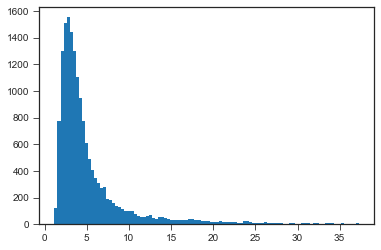

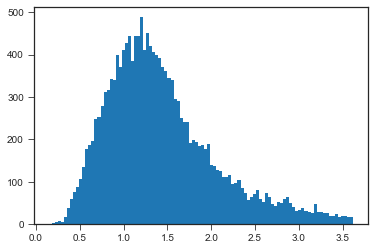

In [11]:
plt.hist(LMEdata.baseline, bins=100)
plt.show()
plt.hist(np.log(LMEdata.baseline), bins=100);

In [12]:
#Taking log as high skew on baseline
LMEdata['logbaseline'] = np.log(LMEdata.baseline)

# SHOULD TRY BY TAKING THE BASELIN NOT IN ABS !

In [13]:
import pickle
import stan_utility
import patsy

LME = stan_utility.compile_model('MixedModels/LME.stan', path='MixedModels/', model_name="LME")

fixeff_form = "1+SAT+Validity+SAT:Validity"#Fixed effects formula
raneff_form = fixeff_form #Random effects formula
fixeff = np.asarray(patsy.dmatrix(fixeff_form, LMEdata)) #FE design matrix
raneff = np.asarray(patsy.dmatrix(raneff_form, LMEdata)) #RE design matrix
prior_intercept = np.asarray([1.5,0.5])#prior for intercept, mu and sigma
priors_mu = np.repeat(0, 3) #Priors on mu for FE
priors_sigma =  np.repeat(0.5, 3) # priors on sigma for FE
priors_raneff = [0, .5] #Priors on RE
prior_sd = [0, .5] #priors on residual sigma

baseline_LME_data = dict(
    N = len(LMEdata),
    P = fixeff.shape[-1], #number of pop level effects
    J = len(LMEdata.participant.unique()),
    n_u = raneff.shape[-1],
    subj = LMEdata.participant,
    X = fixeff,
    Z_u = raneff,
    y = LMEdata.logbaseline.values,
    p_intercept = prior_intercept, p_sd = prior_sd, p_fmu = priors_mu, p_fsigma = priors_sigma, p_r = priors_raneff,
    logT = 1
)

if os.path.exists("MixedModels/FittedModels/baseline_stim_fit.nc"):
    baseline_fit = az.from_netcdf("MixedModels/FittedModels/baseline_stim_fit.nc")

else:
    baseline_fit = LME.sampling(data=baseline_LME_data, iter=2000, chains=6, n_jobs=6, 
                              warmup = 1000,thin=2)
    baseline_fit = az.from_pystan(posterior=baseline_fit, posterior_predictive='y_hat', observed_data="y", log_likelihood='log_lik')
    baseline_fit.to_netcdf("MixedModels/FittedModels/baseline_stim_fit.nc")


Using cached StanModel


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


TypeError: illegal data type for attribute b'args', must be one of dict_keys(['S1', 'i1', 'u1', 'i2', 'u2', 'i4', 'u4', 'i8', 'u8', 'f4', 'f8']), got O

# Inspecting LMM on baseline and slope

## Baseline

In [14]:
#baseline_fit = az.from_netcdf('MixedModels/FittedModels/baseline_fit_abs.nc')

/home/gabriel/anaconda3/envs/pystan/lib/python3.8/site-packages/arviz/utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(


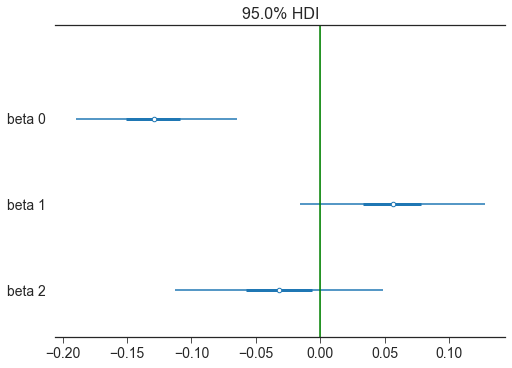

In [14]:
g = az.plot_forest(baseline_fit, var_names="beta", credible_interval=0.95, 
                   combined=True, figsize=(7,5), rope=(0,0))
plt.vlines(0, -1, 10, 'g')
plt.show()


In [16]:
az.summary(baseline_fit, var_names=["alpha","beta"], round_to=2, credible_interval=.95)

ValueError: Can not extract posterior from Inference data with groups:
	> ! See /home/gabriel/anaconda3/envs/pystan/lib/python3.8/site-packages/arviz/data/converters.py for other conversion utilities.

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta\nSAT'}>,
        <AxesSubplot:title={'center':'beta\nSAT'}>],
       [<AxesSubplot:title={'center':'beta\nValidity'}>,
        <AxesSubplot:title={'center':'beta\nValidity'}>],
       [<AxesSubplot:title={'center':'beta\nSAT:Validity'}>,
        <AxesSubplot:title={'center':'beta\nSAT:Validity'}>]],
      dtype=object)

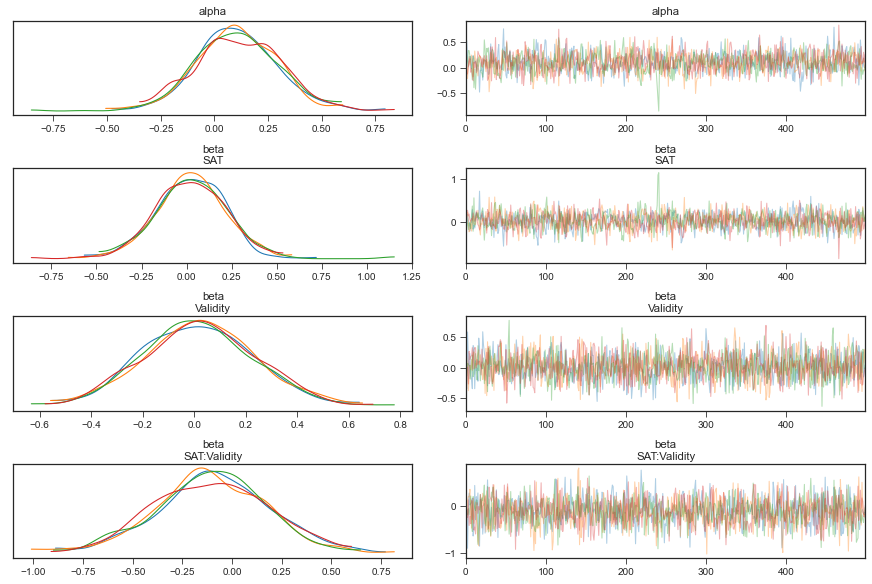

In [10]:
az.plot_trace(baseline_fit, var_names=['alpha','beta'])

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta\n0'}>,
        <AxesSubplot:title={'center':'beta\n0'}>],
       [<AxesSubplot:title={'center':'beta\n1'}>,
        <AxesSubplot:title={'center':'beta\n1'}>],
       [<AxesSubplot:title={'center':'beta\n2'}>,
        <AxesSubplot:title={'center':'beta\n2'}>]], dtype=object)

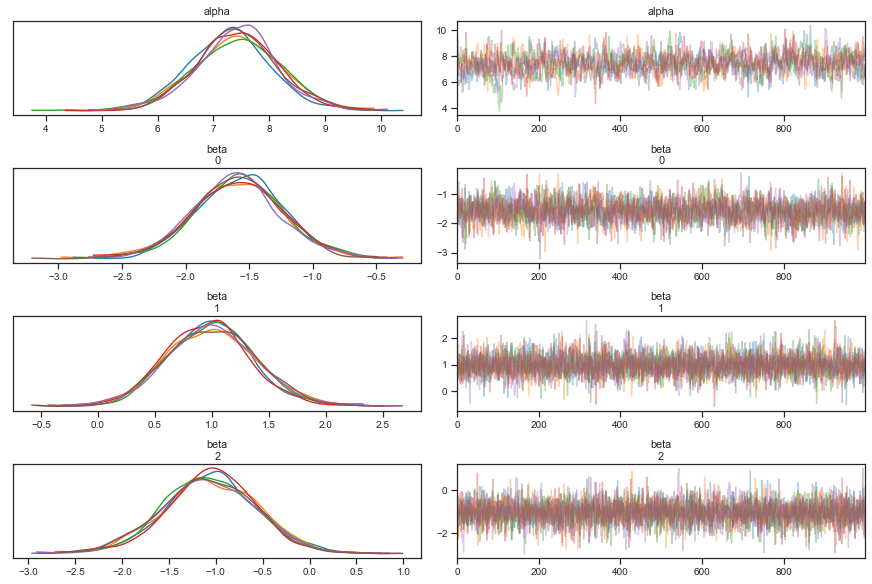

In [27]:
az.plot_trace(baseline_fit, var_names=['alpha','beta'])

<AxesSubplot:xlabel='y / y_hat'>

/home/gabriel/anaconda3/envs/pystan/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


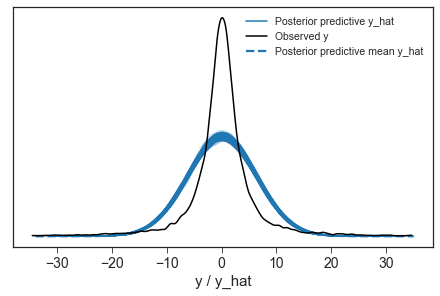

In [11]:
az.plot_ppc(baseline_fit, data_pairs = {'y' : 'y_hat'})

<AxesSubplot:xlabel='baseline', ylabel='Density'>

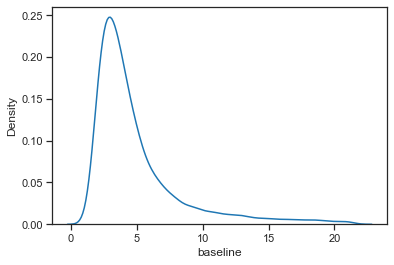

In [46]:
sns.kdeplot(LMEdata[LMEdata.baseline < LMEdata.baseline.std()*2].baseline)


In [47]:
LMEdata[LMEdata.baseline < LMEdata.baseline.std()*2].count()/LMEdata.count()

Unnamed: 0     0.959483
slope          0.959483
baseline       0.959483
participant    0.959483
SAT            0.959483
Validity       0.959483
dtype: float64

In [48]:
LMEdata[LMEdata.baseline < LMEdata.baseline.std()*2].groupby('participant').count()/LMEdata.groupby('participant').count()

Unnamed: 0     slope  baseline       SAT  Validity
participant                                                    
1              0.986822  0.986822  0.986822  0.986822  0.986822
2              0.984389  0.984389  0.984389  0.984389  0.984389
3              0.980975  0.980975  0.980975  0.980975  0.980975
4              0.917507  0.917507  0.917507  0.917507  0.917507
5              0.937716  0.937716  0.937716  0.937716  0.937716
6              0.980198  0.980198  0.980198  0.980198  0.980198
7              0.896497  0.896497  0.896497  0.896497  0.896497
8              0.977021  0.977021  0.977021  0.977021  0.977021
9              0.982347  0.982347  0.982347  0.982347  0.982347
10             0.993421  0.993421  0.993421  0.993421  0.993421
11             0.896918  0.896918  0.896918  0.896918  0.896918
12             0.933230  0.933230  0.933230  0.933230  0.933230
13             0.992019  0.992019  0.992019  0.992019  0.992019
14             0.910811  0.910811  0.910811  0.910811  0.910811
15             0.985063  0.985063  0.985063  0.985063  0.985063
16             0.986087  0.986087  0.986087  0.986087  0.986087

In [15]:
def plot_resid(fit):
    from scipy.stats import probplot
    observed = fit.observed_data.y.values 
    predicted = np.mean(fit.posterior_predictive.y_hat.values, axis=(0,1)) 
    residuals = observed - predicted
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=[15,7])
    probplot(residuals, dist="norm", plot=ax1)
    ax2.plot(np.sort(observed, kind='mergesort'), residuals, '.')
    ax2.plot([observed.min(), observed.max()],[0,0],linestyle='--', color='r')

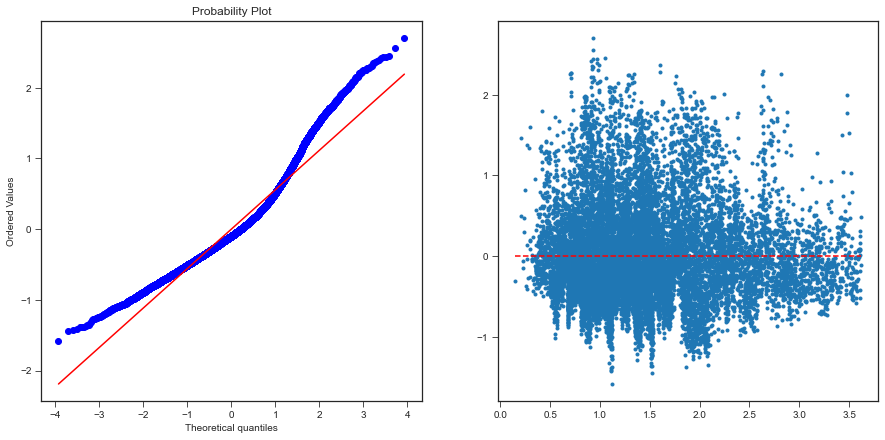

In [16]:
plot_resid(baseline_fit)

## Slope

In [17]:
slope_fit = az.from_netcdf('MixedModels/FittedModels/slope_fit.nc')

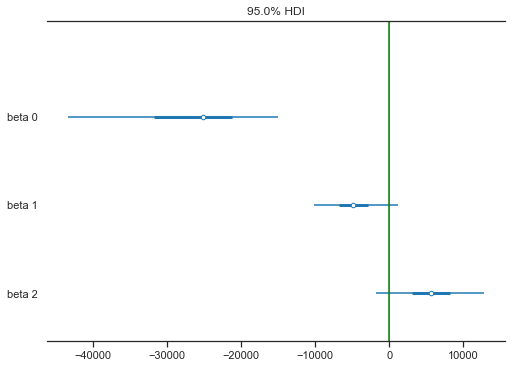

In [51]:
g = az.plot_forest(slope_fit, var_names="beta", credible_interval=0.95, 
                   combined=True, figsize=(7,5), rope=(0,0))
plt.vlines(0, -1, 10, 'g')
plt.show()


In [52]:
az.summary(slope_fit, var_names=["alpha","beta"], round_to=2, credible_interval=.95)

mean        sd    hdi_3%    hdi_97%  mcse_mean  mcse_sd  \
alpha    72719.19  16544.69  42833.38  102016.27    6236.14  4606.46   
beta[0] -26841.31   7738.07 -42215.83  -14985.25    2634.86  1930.04   
beta[1]  -4753.06   2960.22  -9973.99     949.05     402.69   286.29   
beta[2]   5585.58   3767.07  -1409.31   12640.17     344.30   244.06   

         ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
alpha        7.04    7.04      7.13     10.56   2.63  
beta[0]      8.62    8.62      9.14     67.32   1.75  
beta[1]     54.04   54.04     54.89     99.92   1.07  
beta[2]    119.71  119.71    115.98    859.45   1.04

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta\n0'}>,
        <AxesSubplot:title={'center':'beta\n0'}>],
       [<AxesSubplot:title={'center':'beta\n1'}>,
        <AxesSubplot:title={'center':'beta\n1'}>],
       [<AxesSubplot:title={'center':'beta\n2'}>,
        <AxesSubplot:title={'center':'beta\n2'}>]], dtype=object)

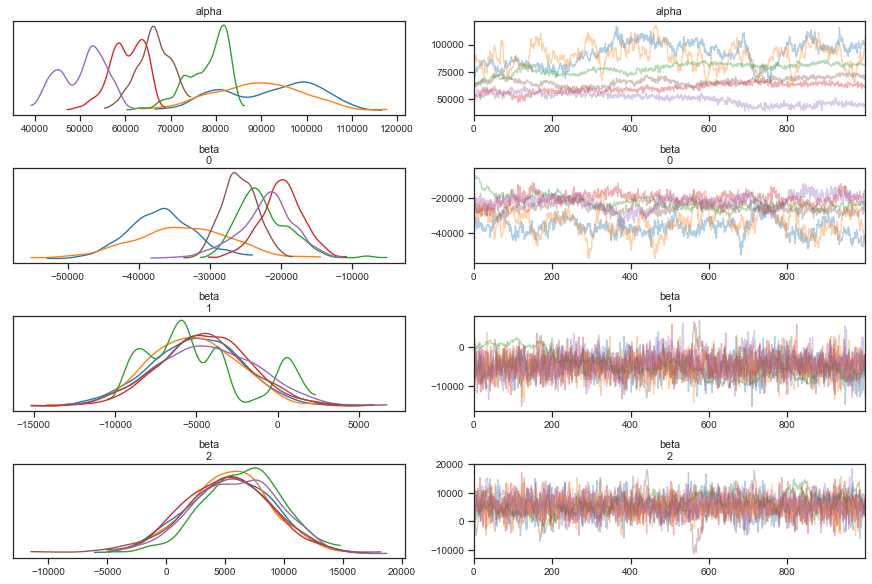

In [53]:
az.plot_trace(slope_fit, var_names=['alpha','beta'])

array([[<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

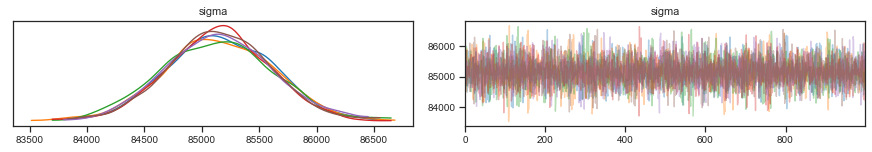

In [65]:
az.plot_trace(slope_fit, var_names=['sigma'])

<AxesSubplot:xlabel='y / y_hat'>

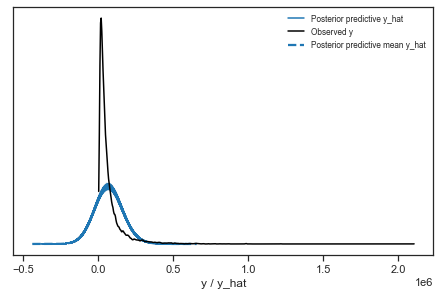

In [54]:
az.plot_ppc(slope_fit, data_pairs = {'y' : 'y_hat'})

<AxesSubplot:xlabel='slope', ylabel='Density'>

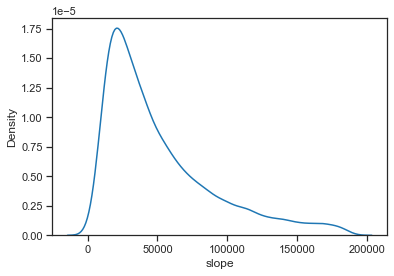

In [57]:
sns.kdeplot(LMEdata[LMEdata.slope < LMEdata.slope.std()*2].slope)


In [64]:
LMEdata[(np.abs(LMEdata.slope) < LMEdata.slope.std()*2) & (np.abs(LMEdata.baseline) < LMEdata.baseline.std()*2)].count()/LMEdata.count()

Unnamed: 0     0.893671
slope          0.893671
baseline       0.893671
participant    0.893671
SAT            0.893671
Validity       0.893671
dtype: float64

In [59]:
LMEdata[LMEdata.slope < LMEdata.slope.std()*2].groupby('participant').count()/LMEdata.groupby('participant').count()

Unnamed: 0     slope  baseline       SAT  Validity
participant                                                    
1              0.991473  0.991473  0.991473  0.991473  0.991473
2              0.991736  0.991736  0.991736  0.991736  0.991736
3              0.902497  0.902497  0.902497  0.902497  0.902497
4              0.920257  0.920257  0.920257  0.920257  0.920257
5              0.982699  0.982699  0.982699  0.982699  0.982699
6              0.963366  0.963366  0.963366  0.963366  0.963366
7              0.958599  0.958599  0.958599  0.958599  0.958599
8              0.949287  0.949287  0.949287  0.949287  0.949287
9              0.946002  0.946002  0.946002  0.946002  0.946002
10             0.902632  0.902632  0.902632  0.902632  0.902632
11             0.931987  0.931987  0.931987  0.931987  0.931987
12             0.827640  0.827640  0.827640  0.827640  0.827640
13             0.989625  0.989625  0.989625  0.989625  0.989625
14             0.902703  0.902703  0.902703  0.902703  0.902703
15             0.724843  0.724843  0.724843  0.724843  0.724843
16             0.962609  0.962609  0.962609  0.962609  0.962609

In [60]:
def plot_resid(fit):
    from scipy.stats import probplot
    observed = fit.observed_data.y.values 
    predicted = np.mean(fit.posterior_predictive.y_hat.values, axis=(0,1)) 
    residuals = observed - predicted
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=[15,7])
    probplot(residuals, dist="norm", plot=ax1)
    ax2.plot(np.sort(observed, kind='mergesort'), residuals, '.')
    ax2.plot([observed.min(), observed.max()],[0,0],linestyle='--', color='r')

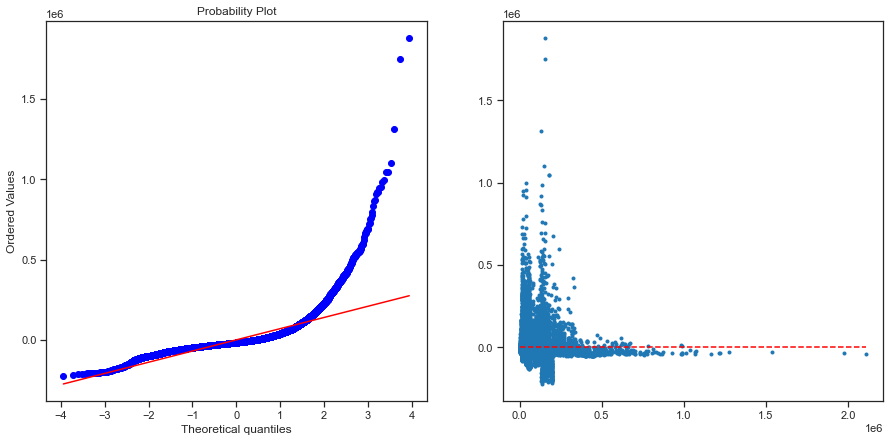

In [61]:
plot_resid(slope_fit)

In [71]:
display_range * intercept+bSAT*0+validity*(bValidity+bSATValidity*0)

array([-4.50746911,  0.        ,  4.50746911])

array([-0.5,  0. ,  0.5])

In [79]:
data

Unnamed: 0         slope   baseline  participant  SAT  Validity
0               0  13207.860361   3.993243            1    1       0.0
1               1  16389.984867  16.559071            1    1      -0.5
2               2  28217.678049   4.745811            1    1       0.5
3               3  20009.428756   4.612840            1    1       0.0
4               4  35448.805152   4.270775            1    1       0.5
...           ...           ...        ...          ...  ...       ...
17469       17469  18447.182426   4.095263           16    1       0.5
17470       17470  21160.012507   3.065738           16    1       0.5
17471       17471  22128.983866   4.209981           16    1       0.5
17472       17472  14736.910780   5.206765           16    1       0.5
17473       17473  11570.092139   3.266251           16    1       0.5

[17474 rows x 6 columns]

ValueError: Sample larger than population or is negative

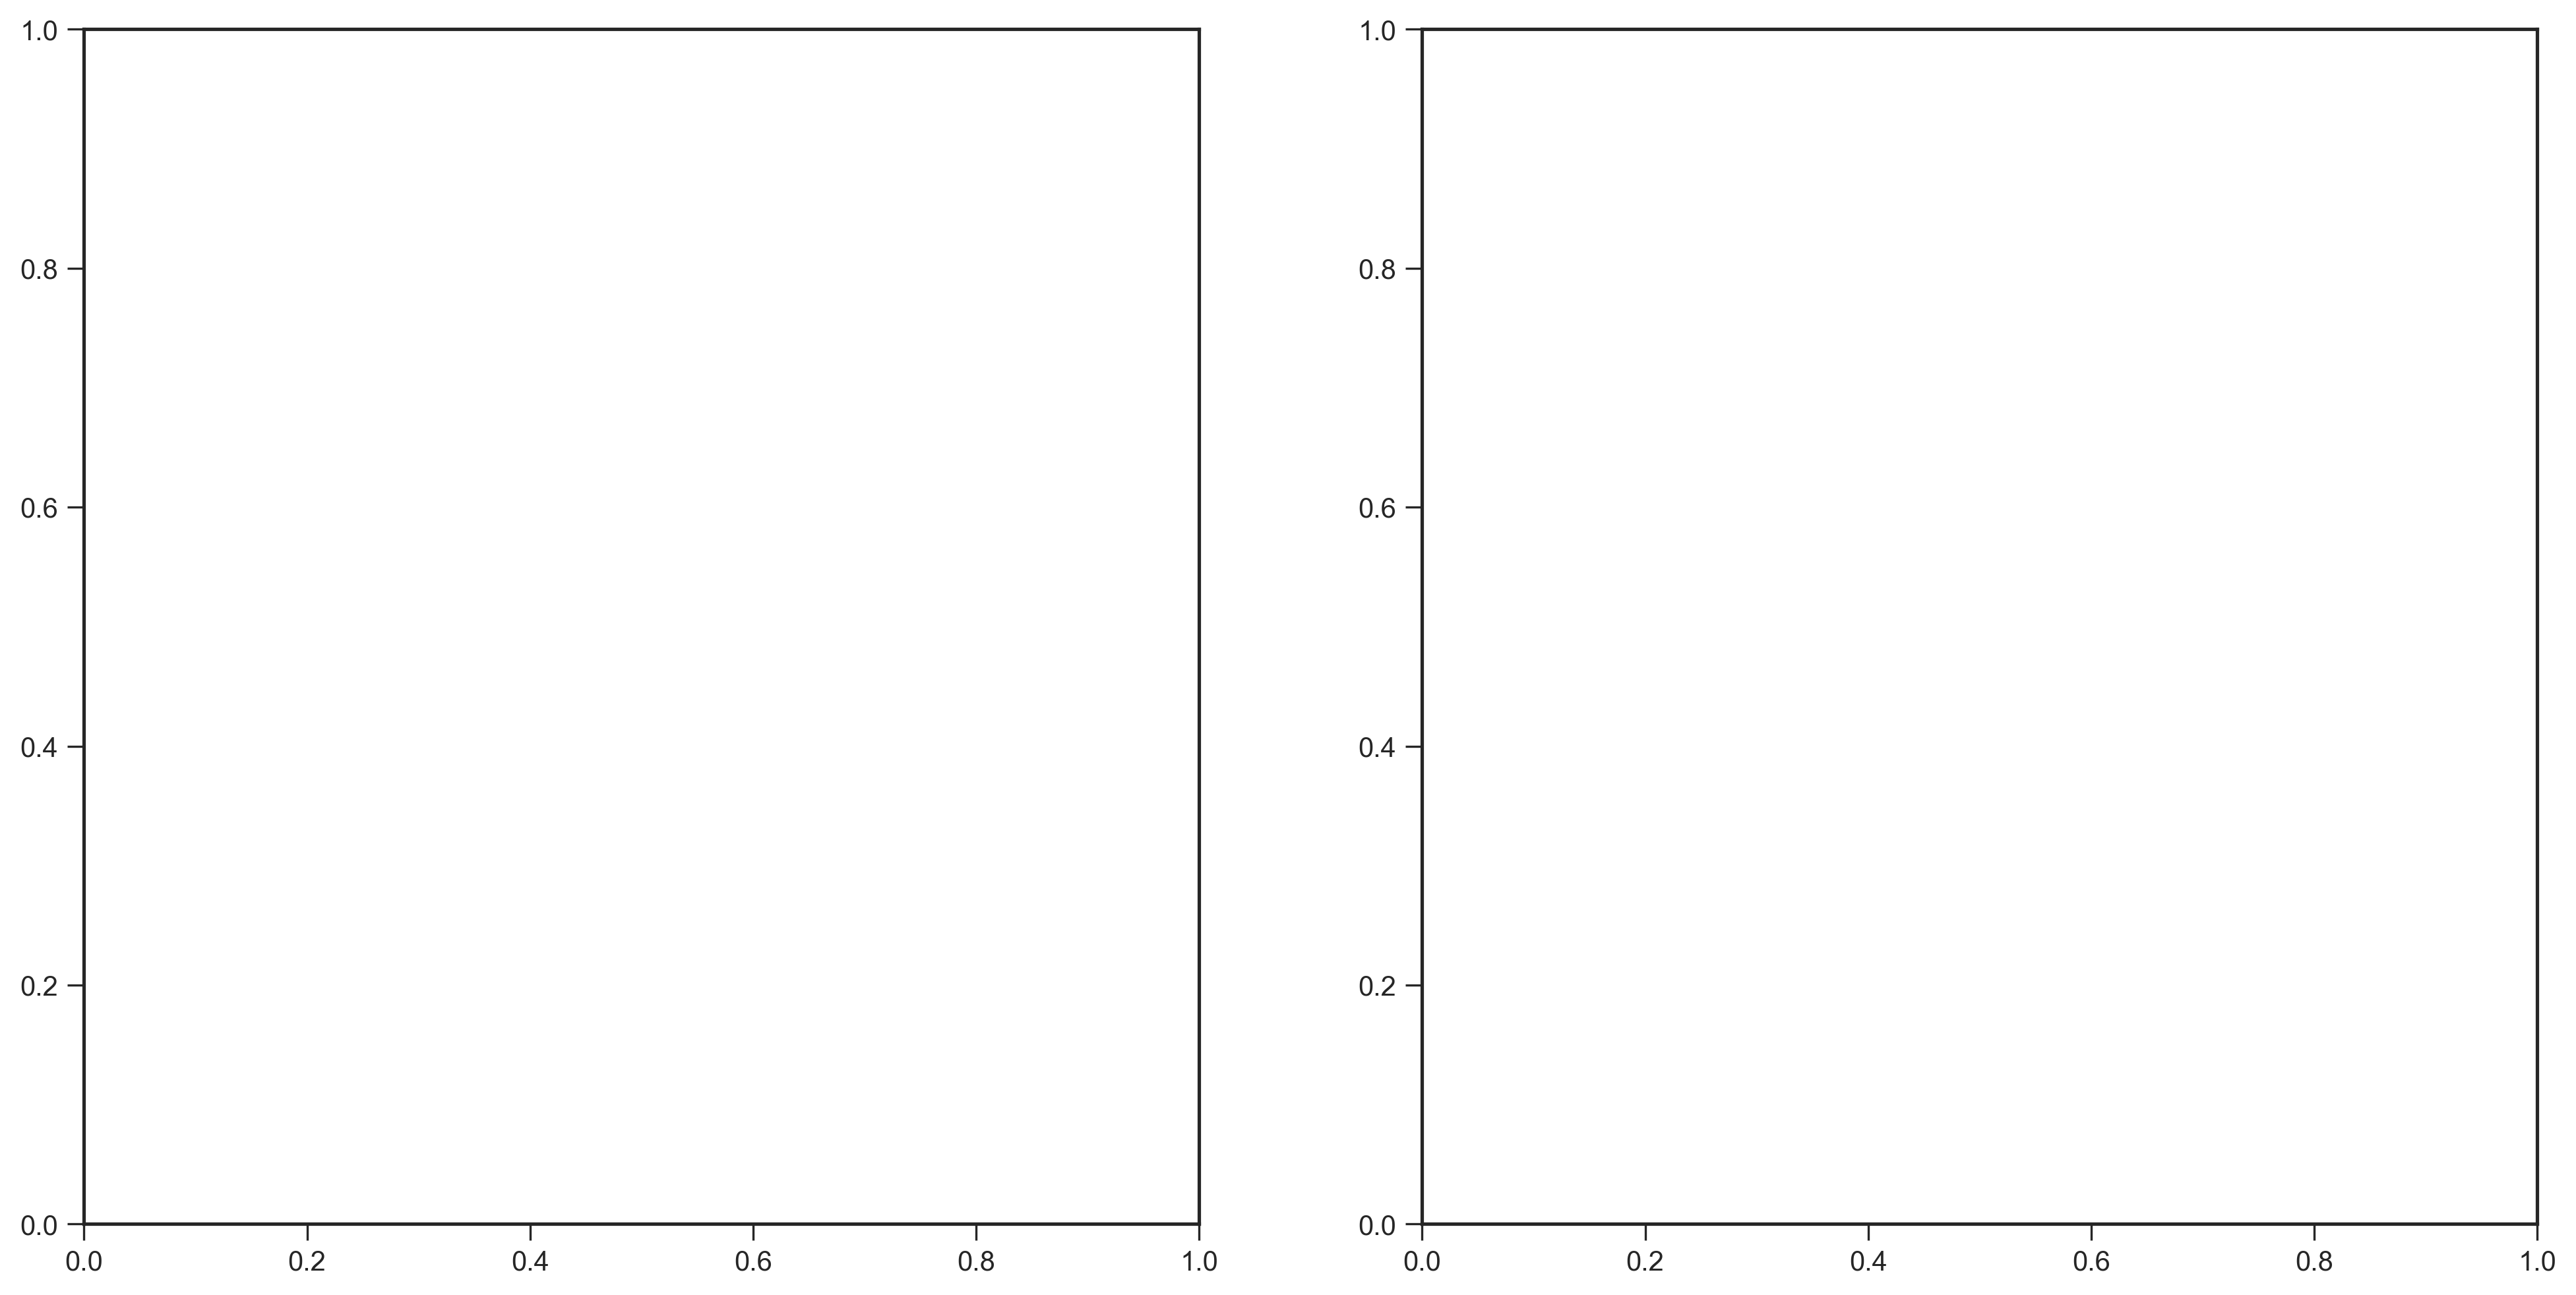

In [18]:
from scipy.special import expit
from random import sample

dv = {'baseline':baseline_fit,'slope':slope_fit}
order = {'baseline':0,'slope':1}

fig, ax = plt.subplots(1,2, sharey=False, figsize=(16,8), sharex=False, dpi=300)

display_range = x = validity = np.asarray([-0.5, 0, .5])

for y in dv.keys():
    fixeff_form = "1+SAT+Validity+SAT:Validity"#Fixed effects formula
    param_dict = {val : idx for idx, val in enumerate(fixeff_form.split('+')[1:])} 
    fit = dv[y]
    j = order[y]
    alpha, beta = fit.posterior.alpha, fit.posterior.beta
    samples,chains = fit.posterior.draw.values,fit.posterior.chain.values
    for z in np.arange(1):
        for d in sample(list(samples),1000):
            c = np.random.choice(chains)
            intercept, bSAT, bValidity, bSATValidity =  \
                alpha.sel(draw=d, chain=c).values, beta.sel(draw=d, chain=c, beta_dim_0=param_dict["SAT"]).values,\
                beta.sel(draw=d, chain=c, beta_dim_0=param_dict["Validity"]).values,\
                beta.sel(draw=d, chain=c, beta_dim_0=param_dict["SAT:Validity"]).values
            ax[j].plot(display_range, intercept+bSAT*0+validity*(bValidity+bSATValidity*0), color="r", alpha=.01)
            ax[j].plot(display_range, intercept+bSAT*1+validity*(bValidity+bSATValidity*1), color="g", alpha=.01)
        intercept, bSAT, bValidity, bSATValidity =  \
            alpha.mean(axis=(0,1)).values, beta.sel(beta_dim_0=param_dict["SAT"]).mean(axis=(0,1)).values,\
            beta.sel(beta_dim_0=param_dict["Validity"]).mean(axis=(0,1)).values, \
            beta.sel(beta_dim_0=param_dict["SAT:Validity"]).mean(axis=(0,1)).values

        ax[j].set_ylabel('%s' %y)
        data = LMEdata.copy()
        data['SAT'] = data.SAT.replace([1,0], ['accuracy','speed'])
        F1 = data[(data.SAT=="accuracy")].groupby(['participant','Validity']).mean().groupby('Validity') #Strong force only
        F2 = data[(data.SAT=="speed")].groupby(['participant','Validity']).mean().groupby('Validity') #Strong force only
        ax[j].plot( x, F1[y].mean().values,'o',color="green", markeredgecolor ="k", label="Accuracy")
        ax[j].plot( x, F2[y].mean().values,'o',color="red", markeredgecolor ="k", label="Speed")
        ax[j].plot(display_range, intercept+bSAT*0+validity*(bValidity+bSATValidity*0), color="darkred")
        ax[j].plot(display_range,intercept+bSAT*1+validity*(bValidity+bSATValidity*1), color="darkgreen")
        ax[j].set_xlabel('Validity')
        if j == 0 and z == 0:
            ax[j].legend(loc=1)
plt.tight_layout()
plt.show()

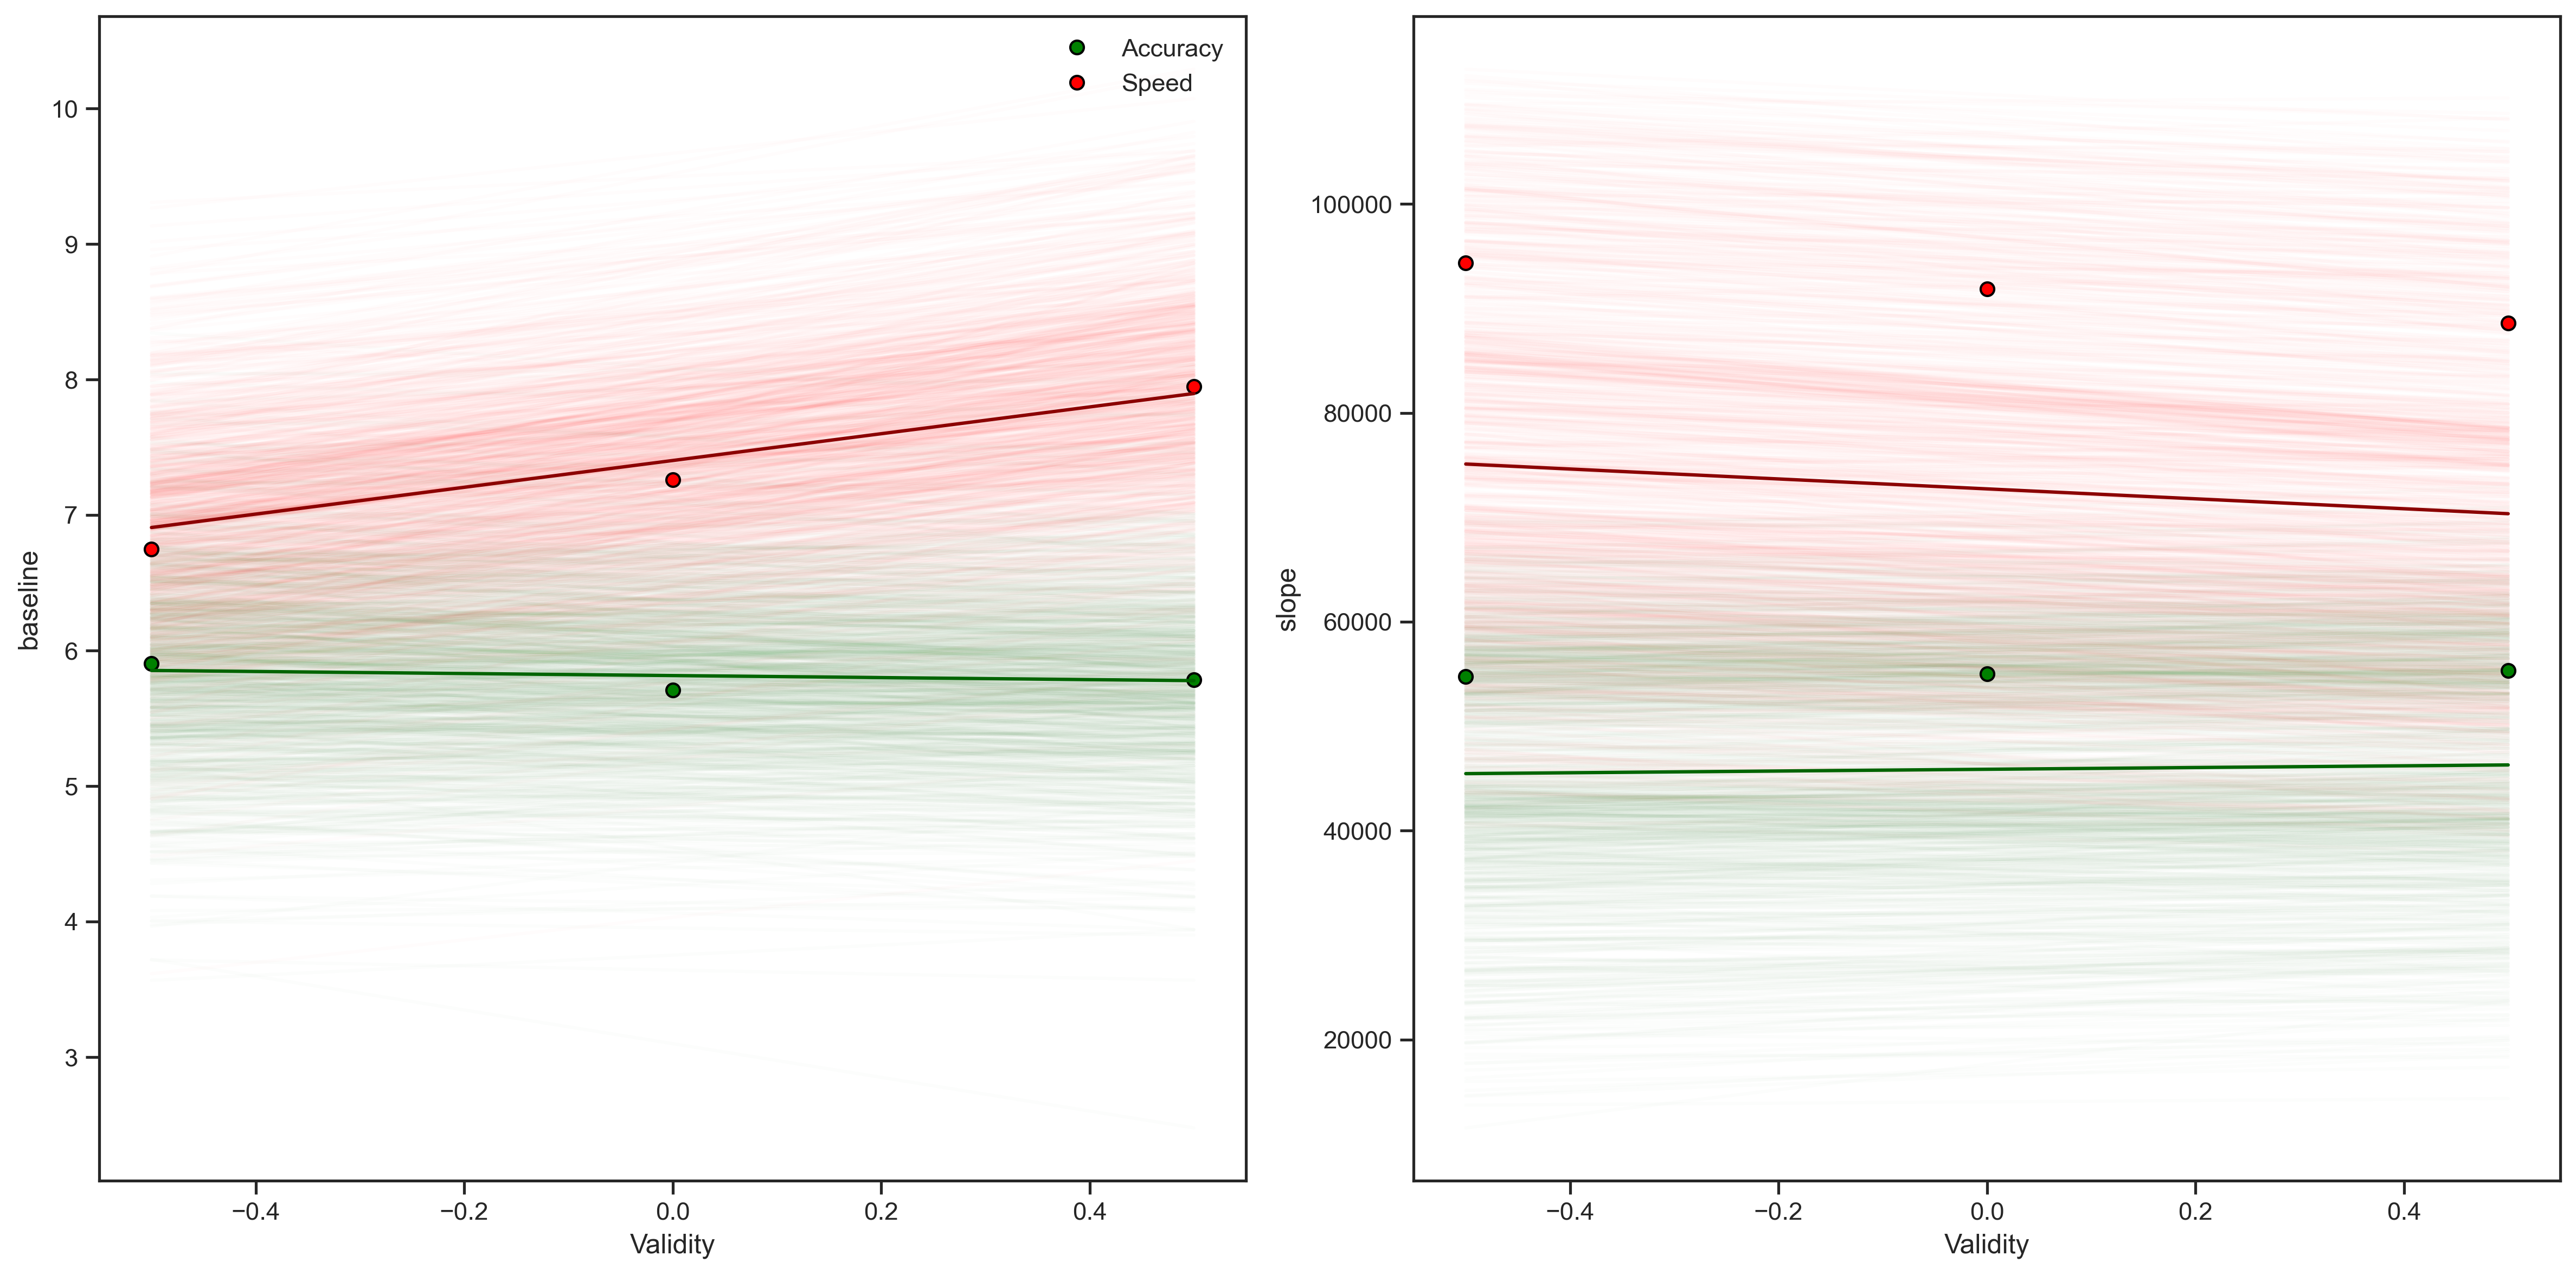

In [81]:
from scipy.special import expit
from random import sample

dv = {'baseline':baseline_fit,'slope':slope_fit}
order = {'baseline':0,'slope':1}

fig, ax = plt.subplots(1,2, sharey=False, figsize=(16,8), sharex=False, dpi=300)

display_range = x = validity = np.asarray([-0.5, 0, .5])

for y in dv.keys():
    fixeff_form = "1+SAT+Validity+SAT:Validity"#Fixed effects formula
    param_dict = {val : idx for idx, val in enumerate(fixeff_form.split('+')[1:])} 
    fit = dv[y]
    j = order[y]
    alpha, beta = fit.posterior.alpha, fit.posterior.beta
    samples,chains = fit.posterior.draw.values,fit.posterior.chain.values
    for z in np.arange(1):
        for d in sample(list(samples),1000):
            c = np.random.choice(chains)
            intercept, bSAT, bValidity, bSATValidity =  \
                alpha.sel(draw=d, chain=c).values, beta.sel(draw=d, chain=c, beta_dim_0=param_dict["SAT"]).values,\
                beta.sel(draw=d, chain=c, beta_dim_0=param_dict["Validity"]).values,\
                beta.sel(draw=d, chain=c, beta_dim_0=param_dict["SAT:Validity"]).values
            ax[j].plot(display_range, intercept+bSAT*0+validity*(bValidity+bSATValidity*0), color="r", alpha=.01)
            ax[j].plot(display_range, intercept+bSAT*1+validity*(bValidity+bSATValidity*1), color="g", alpha=.01)
        intercept, bSAT, bValidity, bSATValidity =  \
            alpha.mean(axis=(0,1)).values, beta.sel(beta_dim_0=param_dict["SAT"]).mean(axis=(0,1)).values,\
            beta.sel(beta_dim_0=param_dict["Validity"]).mean(axis=(0,1)).values, \
            beta.sel(beta_dim_0=param_dict["SAT:Validity"]).mean(axis=(0,1)).values

        ax[j].set_ylabel('%s' %y)
        data = LMEdata.copy()
        data['SAT'] = data.SAT.replace([1,0], ['accuracy','speed'])
        F1 = data[(data.SAT=="accuracy")].groupby(['participant','Validity']).mean().groupby('Validity') #Strong force only
        F2 = data[(data.SAT=="speed")].groupby(['participant','Validity']).mean().groupby('Validity') #Strong force only
        ax[j].plot( x, F1[y].mean().values,'o',color="green", markeredgecolor ="k", label="Accuracy")
        ax[j].plot( x, F2[y].mean().values,'o',color="red", markeredgecolor ="k", label="Speed")
        ax[j].plot(display_range, intercept+bSAT*0+validity*(bValidity+bSATValidity*0), color="darkred")
        ax[j].plot(display_range,intercept+bSAT*1+validity*(bValidity+bSATValidity*1), color="darkgreen")
        ax[j].set_xlabel('Validity')
        if j == 0 and z == 0:
            ax[j].legend(loc=1)
plt.tight_layout()
plt.show()

## MERGE S10 et S14 (et DROP S12 PART 2)

In [7]:
mean_L = [np.mean(x[:100]) for x in raw_.groupby('epoch').EMG_L]

/home/gabriel/anaconda3/envs/pystan/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [34]:
raw_ = pd.read_table(epochPath+'S2.csv', header=0, sep=',',skipinitialspace=True,
            usecols=["epoch","time","condition","EMG_L","EMG_R"],
            dtype=column_types) #skiprows=1, skipfooter=1
raw_['R_channel'] = np.nan
for epoch, epoch_dat in raw_.groupby('epoch'):
    rep = epoch_dat.condition.unique()[0].split('/')[1]
    if rep == "G":
        raw_.loc[raw_.epoch == epoch, "R_channel"] = epoch_dat["EMG_L"]
    else : 
        raw_.loc[raw_.epoch == epoch, "R_channel"] = epoch_dat["EMG_R"]
#raw_['average'] = (raw_['EMG_L']+raw_['EMG_R'])/2 #Tres sale !!!!!
#raw_ = raw_.groupby(['condition','time']).average.mean()
#raw_ = raw_.reset_index()
raw_['SAT'], raw_['direction'], raw_['p_right'] = \
       zip(*raw_['condition'].map(lambda y: y.split('/')))
#del raw_['condition']
#raw_['participant'] = "S2"
raw_["direction"]= raw_.apply(lambda row: "right" if row['direction'] == "D" else "left", axis=1)
raw_["valid"] = raw_.apply(lambda row : "valid" if row['direction'] == "right" and row['p_right'] == '70' else 
                  ("valid" if row['direction'] == "left" and row['p_right'] == '30' else 
                  ("even" if row['p_right'] == '50' else "invalid" )), axis = 1)


In [5]:
epoch_dat.condition.unique()[0].split('/')[1]


'D'

In [31]:
grp_avrg

time    valid  SAT  R_channel
0    -0.100098     even  Acc   1.813588
1    -0.100098     even  Spd   2.690918
2    -0.100098  invalid  Acc   2.029189
3    -0.100098  invalid  Spd   2.099500
4    -0.100098    valid  Acc   2.313756
...        ...      ...  ...        ...
7375  0.500000     even  Spd   2.535212
7376  0.500000  invalid  Acc   1.944527
7377  0.500000  invalid  Spd   2.178839
7378  0.500000    valid  Acc   2.472462
7379  0.500000    valid  Spd   2.287662

[7380 rows x 4 columns]

(-0.01, 0.06)

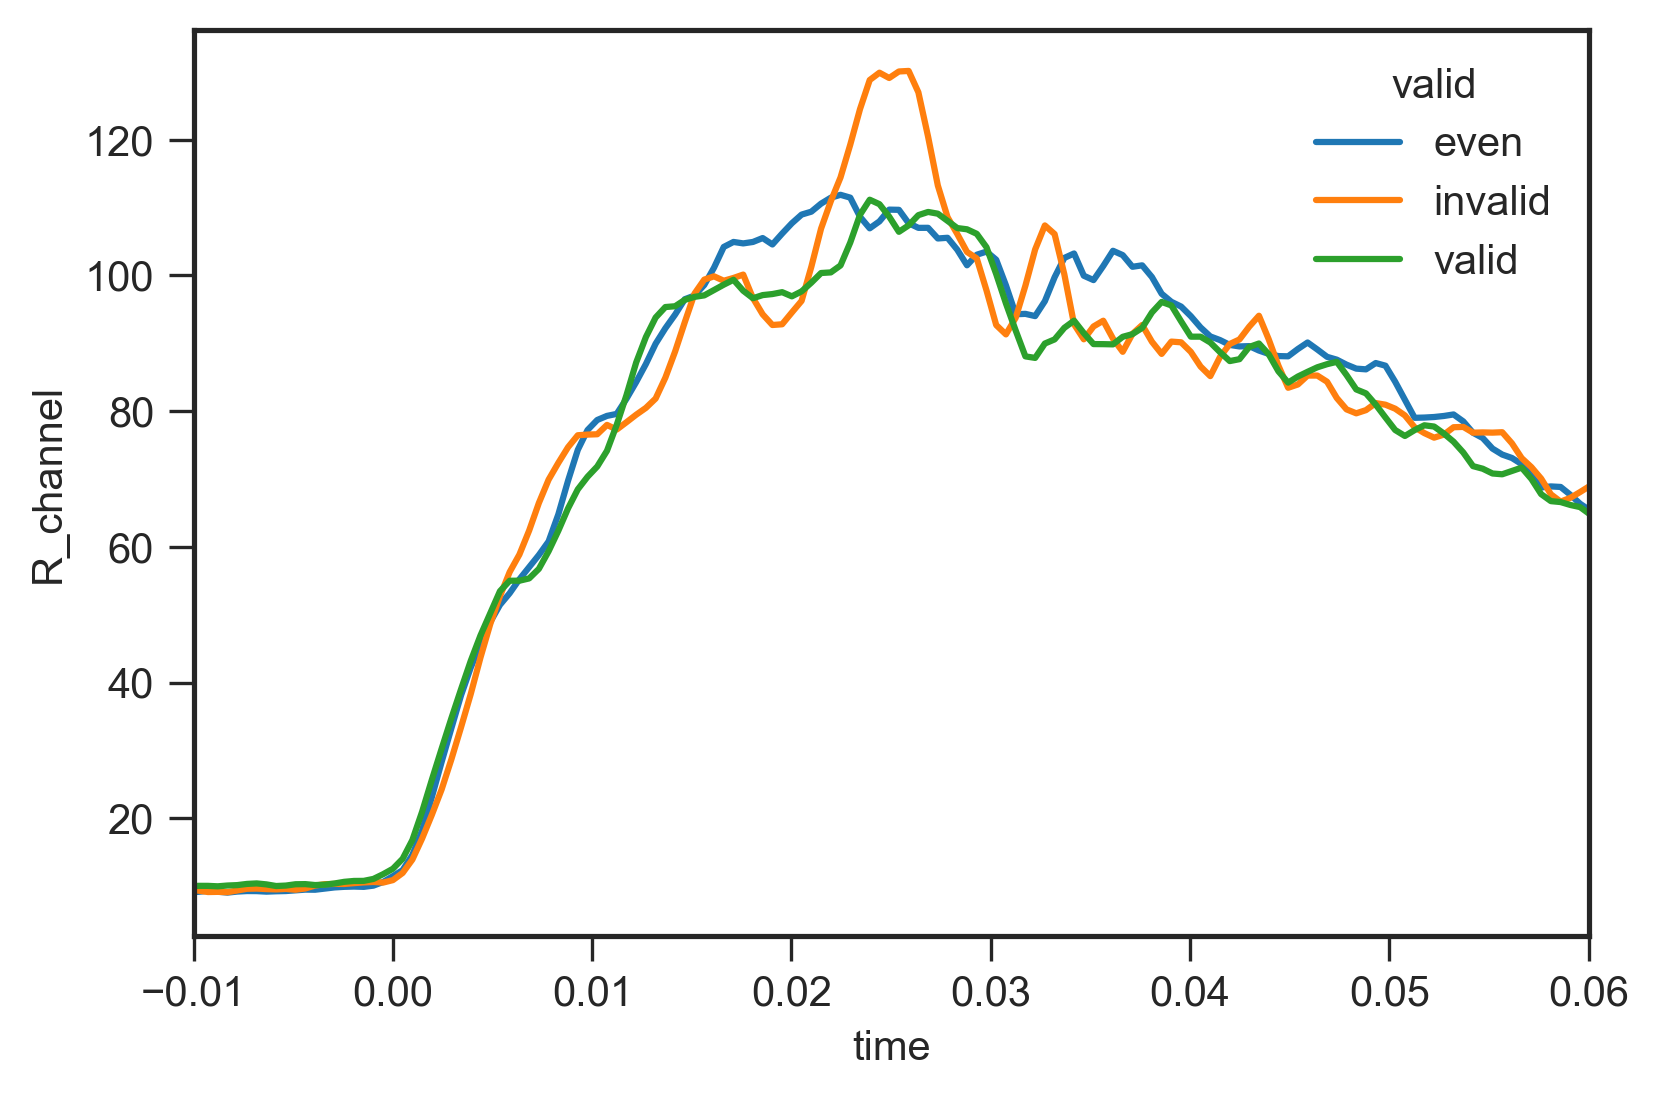

In [40]:
plt.figure(dpi=300)
grp_avrg = raw_.groupby(['time','valid','SAT']).R_channel.mean().reset_index()
sns.lineplot(data=grp_avrg[grp_avrg.SAT == "Spd"], x='time', y="R_channel", hue="valid",ci=False)
plt.xlim(-.010, .060)

<AxesSubplot:xlabel='time', ylabel='R_channel'>

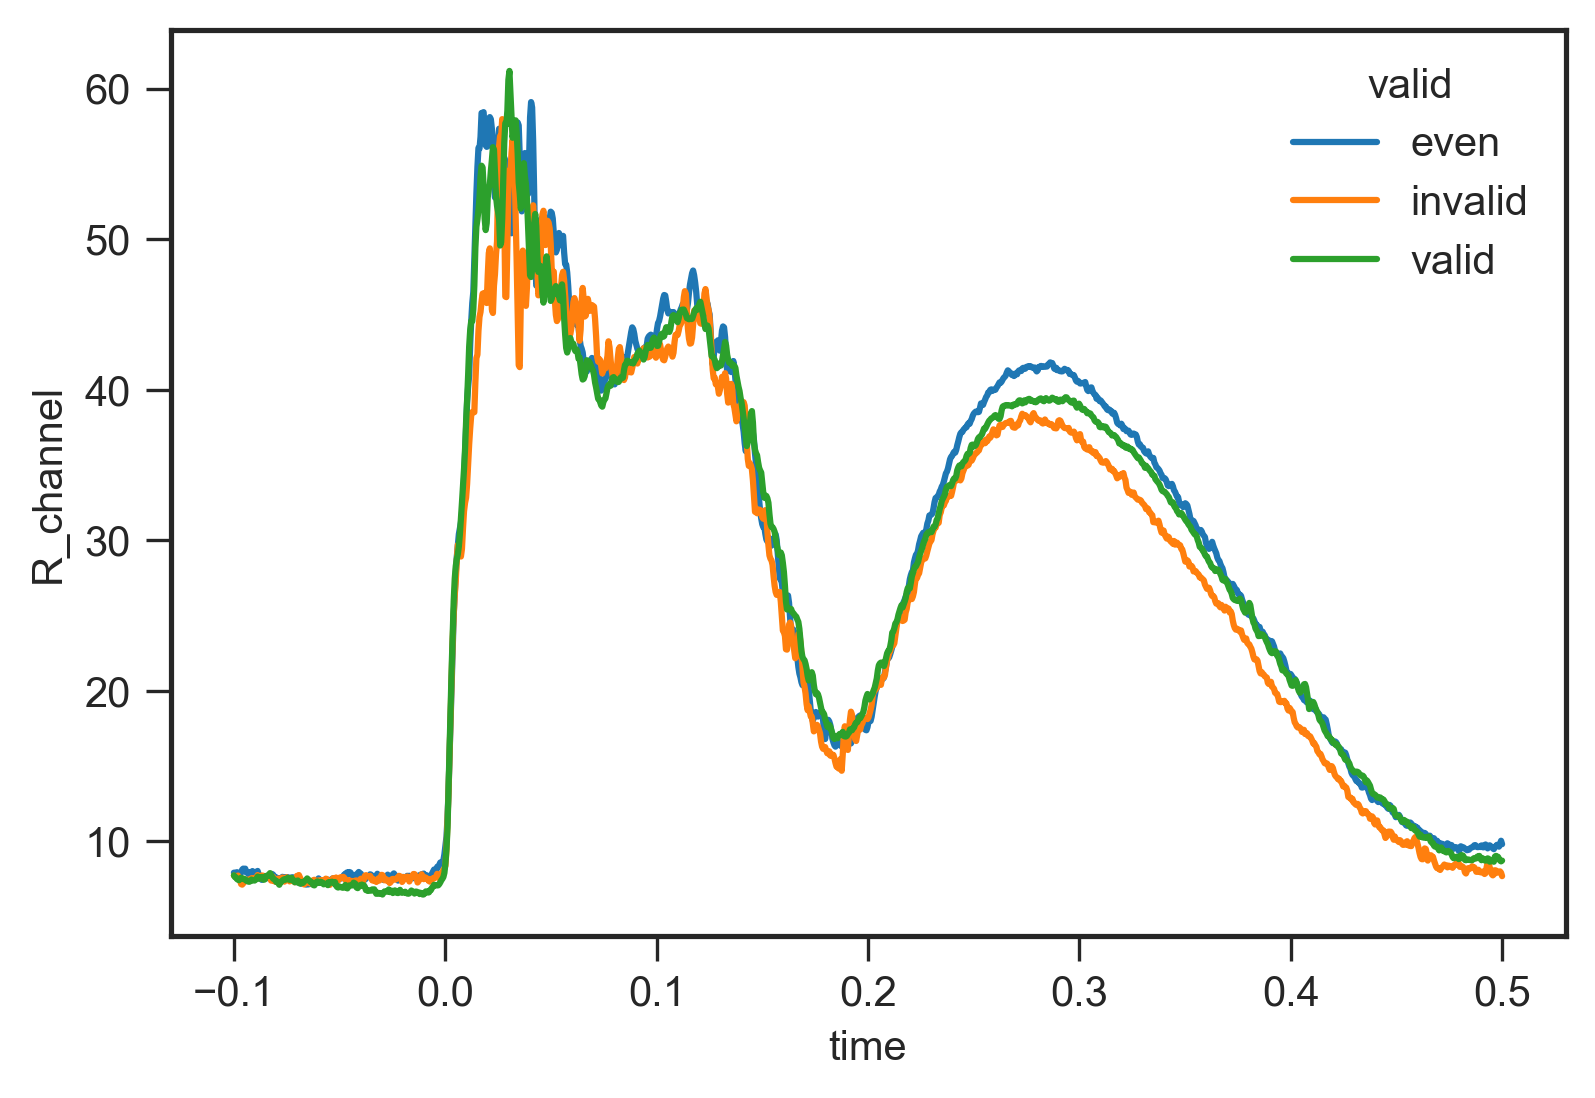

In [38]:
plt.figure(dpi=300)
grp_avrg = raw_.groupby(['time','valid','SAT']).R_channel.mean().reset_index()
sns.lineplot(data=grp_avrg[grp_avrg.SAT == "Acc"], x='time', y="R_channel", hue="valid",ci=False)


(-0.01, 0.1)

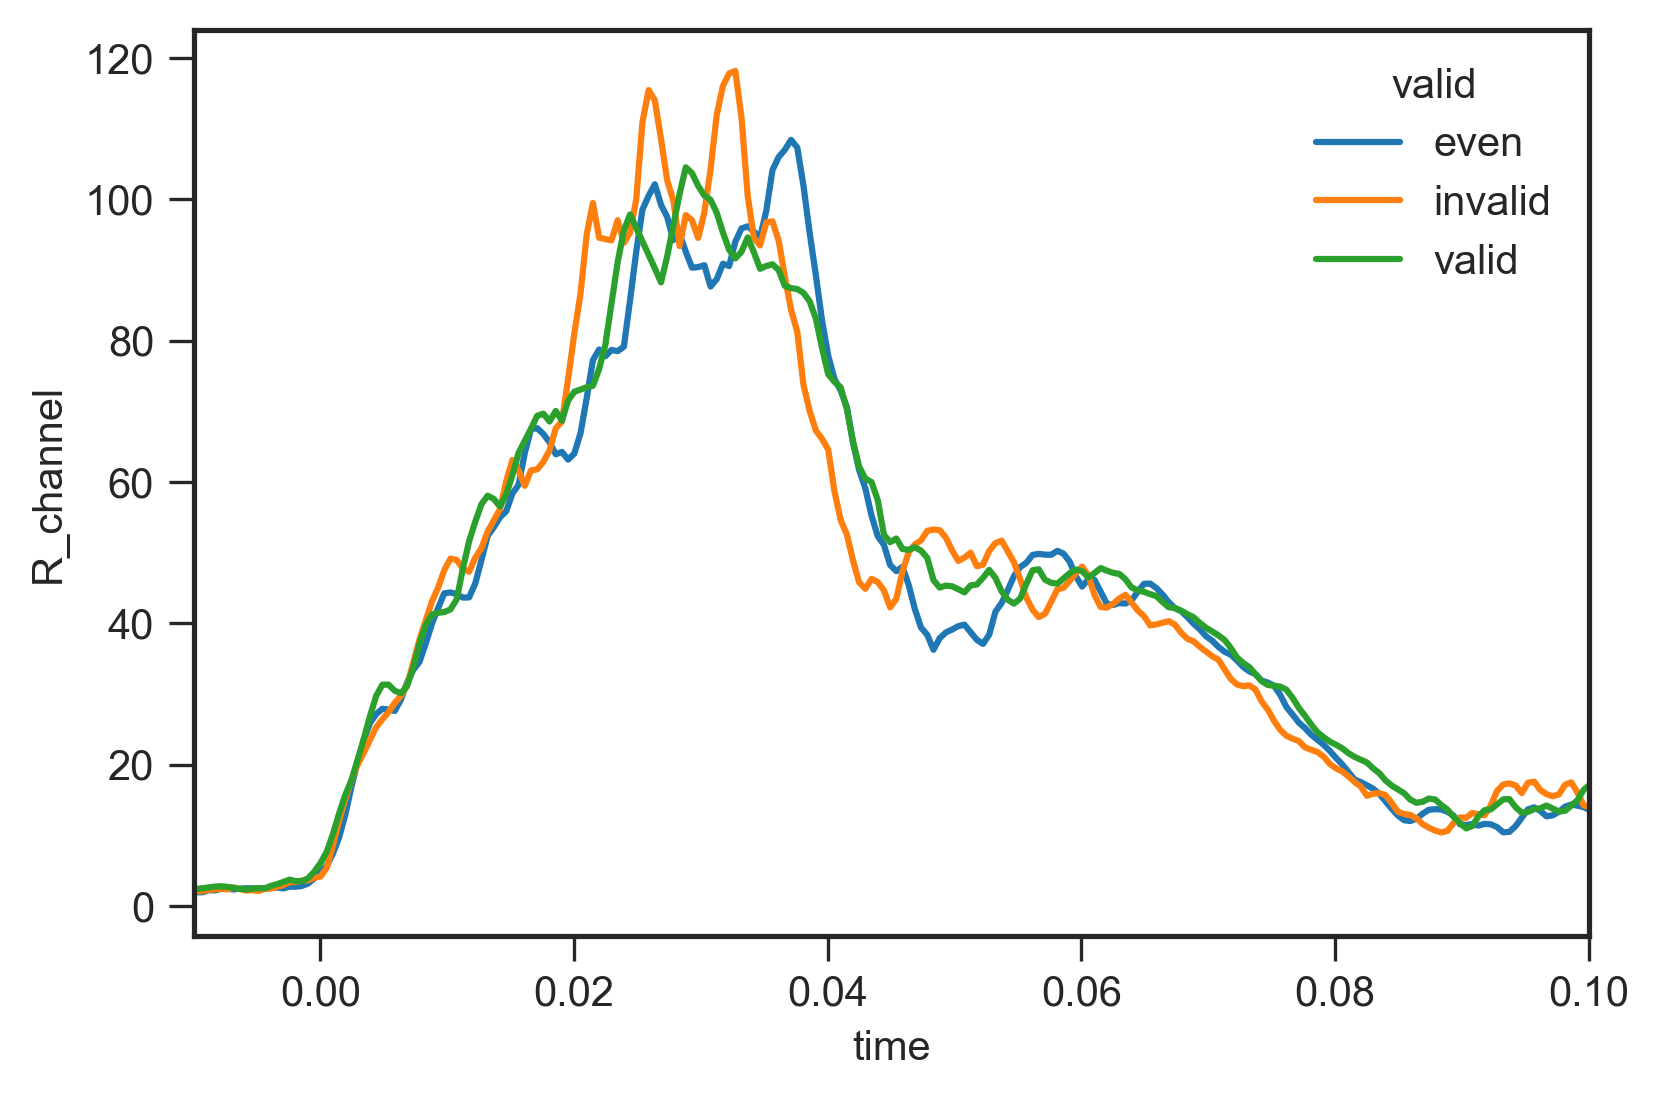

In [32]:
plt.figure(dpi=300)
grp_avrg = raw_.groupby(['time','valid','SAT']).R_channel.mean().reset_index()
sns.lineplot(data=grp_avrg[grp_avrg.SAT == "Spd"], x='time', y="R_channel", hue="valid",ci=False)
plt.xlim(-.010, .100)

(-0.01, 0.1)

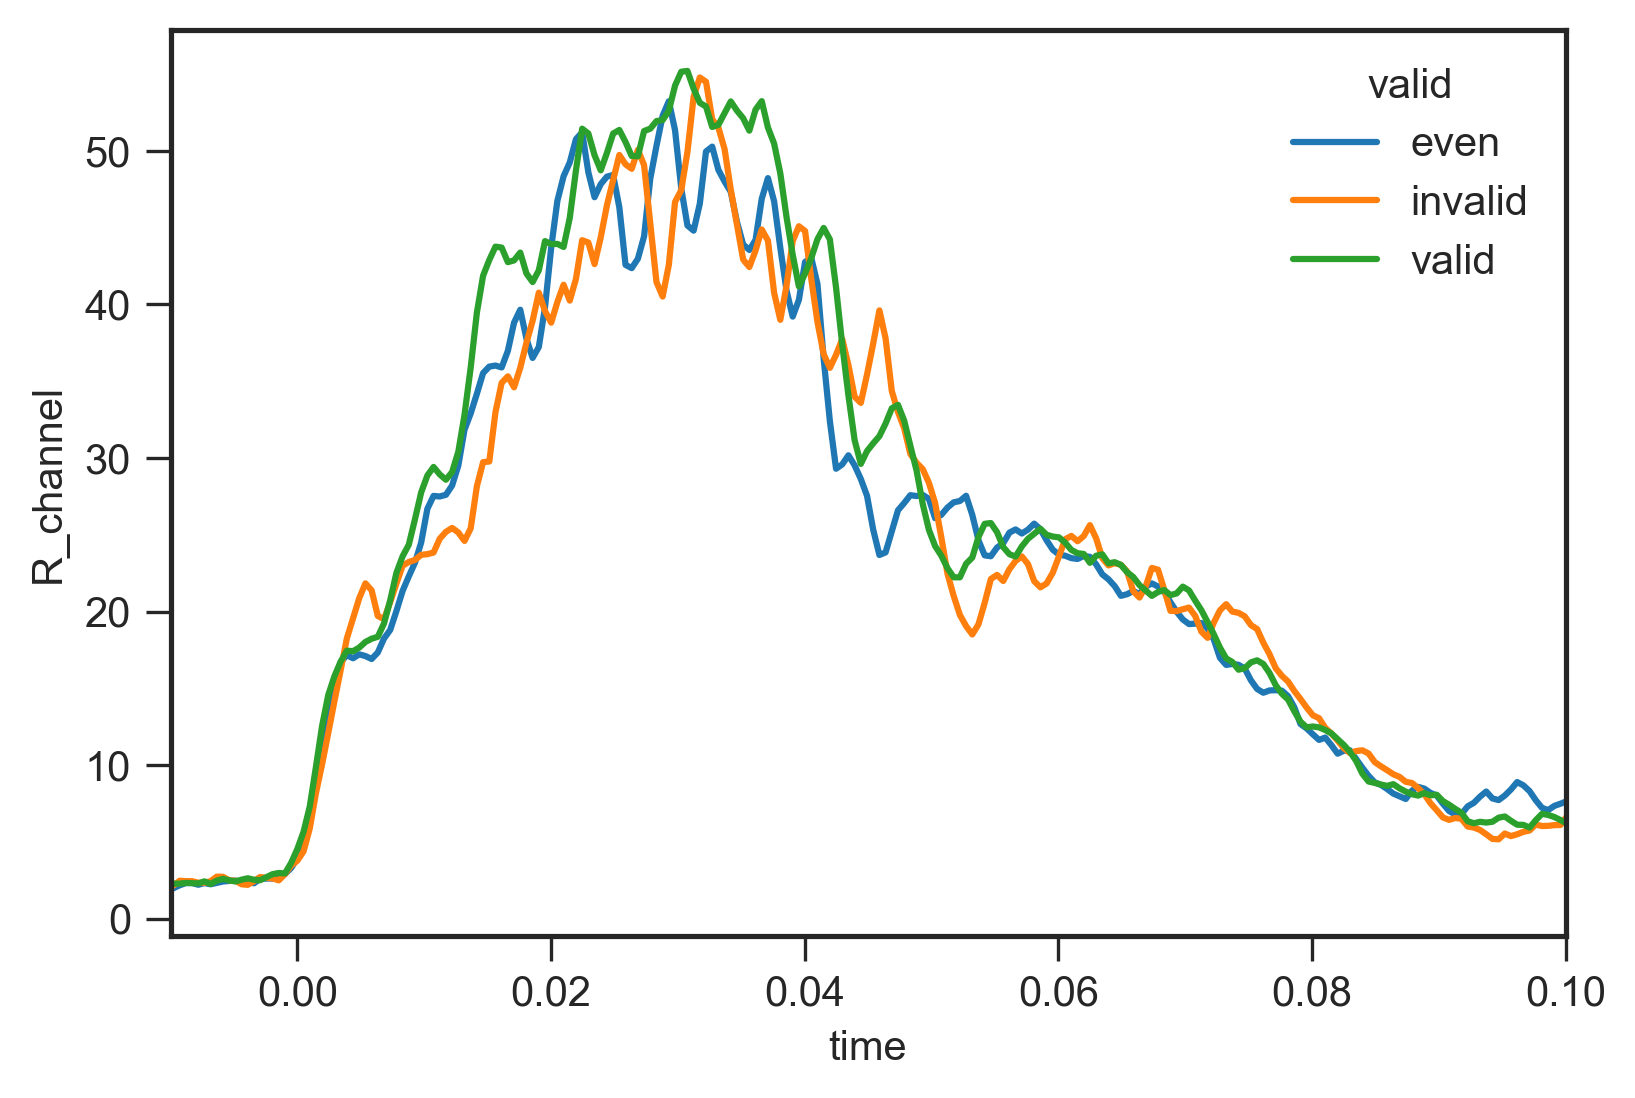

In [33]:
plt.figure(dpi=300)
grp_avrg = raw_.groupby(['time','valid','SAT']).R_channel.mean().reset_index()
sns.lineplot(data=grp_avrg[grp_avrg.SAT == "Acc"], x='time', y="R_channel", hue="valid",ci=False)
plt.xlim(-.010, .100)

<AxesSubplot:xlabel='time', ylabel='R_channel'>

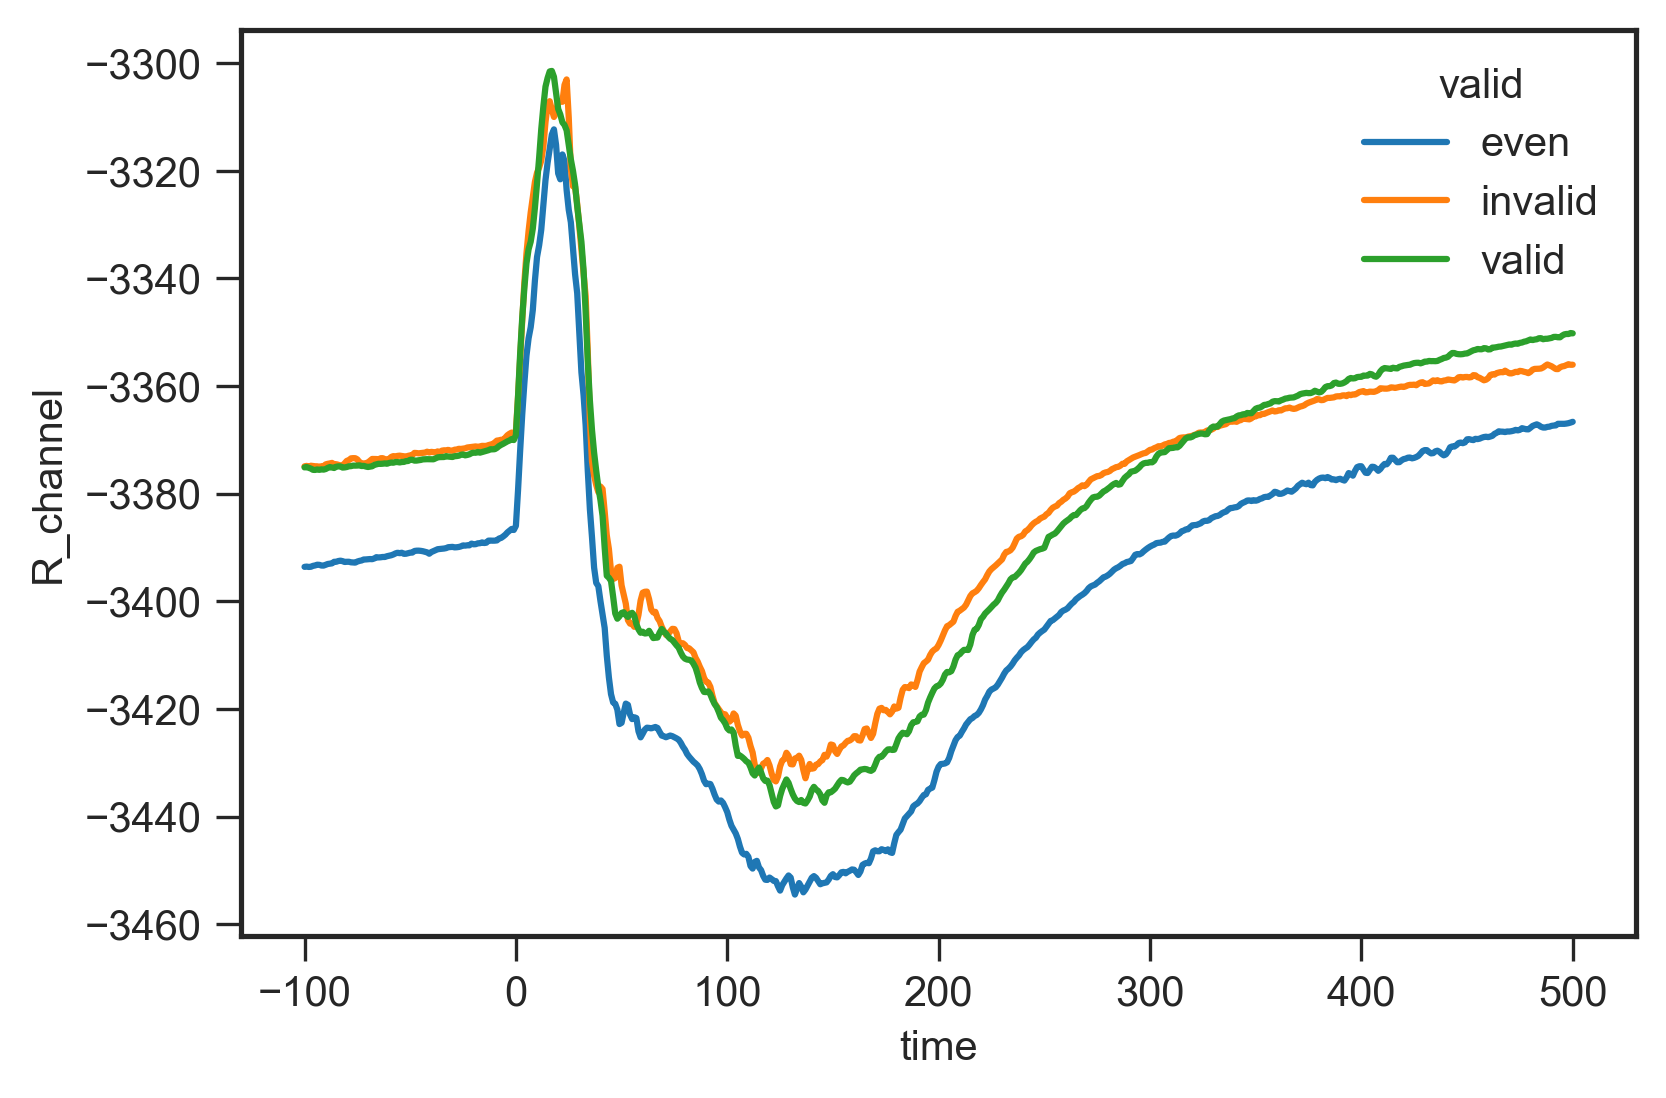

In [6]:
plt.figure(dpi=300)
grp_avrg = raw_.groupby(['time','valid']).R_channel.mean().reset_index()
sns.lineplot(data=grp_avrg, x='time', y="R_channel", hue="valid",ci=False)

In [42]:
test = raw_.loc[raw_.epoch == 0]

In [45]:
test['cumsum'] = np.cumsum(test.R_channel)

<ipython-input-45-837384f680be>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['cumsum'] = np.cumsum(test.R_channel)


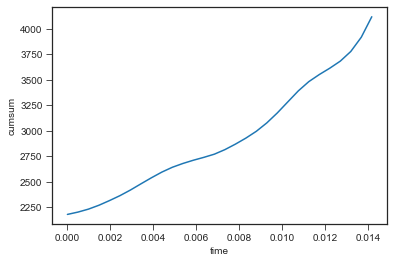

In [52]:
sns.lineplot(data=test[205:235], x='time', y="cumsum",ci=False)
plt.show()

In [73]:
spss.linregress(x=epoch_dat.time[205:235], y=np.cumsum(epoch_dat.R_channel[205:235]))[0]

208532.39201534938

In [53]:
test[205:235]

epoch      time condition     EMG_L       EMG_R   R_channel  SAT  \
205      0  0.000000  Acc/D/70  2.018771   23.468557   23.468557  Acc   
206      0  0.000488  Acc/D/70  2.053263   22.747496   22.747496  Acc   
207      0  0.000977  Acc/D/70  0.249446   29.071107   29.071107  Acc   
208      0  0.001465  Acc/D/70  1.416347   38.159204   38.159204  Acc   
209      0  0.001953  Acc/D/70  2.077655   45.508497   45.508497  Acc   
210      0  0.002441  Acc/D/70  3.576081   48.574838   48.574838  Acc   
211      0  0.002930  Acc/D/70  3.601064   55.235229   55.235229  Acc   
212      0  0.003418  Acc/D/70  3.189707   60.763273   60.763273  Acc   
213      0  0.003906  Acc/D/70  4.213937   59.682649   59.682649  Acc   
214      0  0.004395  Acc/D/70  5.044937   56.021540   56.021540  Acc   
215      0  0.004883  Acc/D/70  4.686936   47.459234   47.459234  Acc   
216      0  0.005371  Acc/D/70  1.464887   37.078984   37.078984  Acc   
217      0  0.005859  Acc/D/70  0.023959   31.901802   31.901802  Acc   
218      0  0.006348  Acc/D/70  0.365593   28.282068   28.282068  Acc   
219      0  0.006836  Acc/D/70  0.036246   31.194995   31.194995  Acc   
220      0  0.007324  Acc/D/70  1.173199   44.339075   44.339075  Acc   
221      0  0.007812  Acc/D/70  2.053979   53.912463   53.912463  Acc   
222      0  0.008301  Acc/D/70  4.674006   59.251429   59.251429  Acc   
223      0  0.008789  Acc/D/70  5.782554   67.266855   67.266855  Acc   
224      0  0.009277  Acc/D/70  6.292320   82.584195   82.584195  Acc   
225      0  0.009766  Acc/D/70  4.368858   97.868405   97.868405  Acc   
226      0  0.010254  Acc/D/70  5.323305  108.383959  108.383959  Acc   
227      0  0.010742  Acc/D/70  7.798408  108.022445  108.022445  Acc   
228      0  0.011230  Acc/D/70  5.896670   90.868796   90.868796  Acc   
229      0  0.011719  Acc/D/70  4.131108   69.674660   69.674660  Acc   
230      0  0.012207  Acc/D/70  4.899797   62.472287   62.472287  Acc   
231      0  0.012695  Acc/D/70  6.037578   69.238529   69.238529  Acc   
232      0  0.013184  Acc/D/70  6.856781   94.872483   94.872483  Acc   
233      0  0.013672  Acc/D/70  6.144323  139.819025  139.819025  Acc   
234      0  0.014160  Acc/D/70  4.844213  201.248754  201.248754  Acc   

    direction p_right  valid       cumsum  
205     right      70  valid  2179.299169  
206     right      70  valid  2202.046666  
207     right      70  valid  2231.117773  
208     right      70  valid  2269.276977  
209     right      70  valid  2314.785474  
210     right      70  valid  2363.360312  
211     right      70  valid  2418.595541  
212     right      70  valid  2479.358814  
213     right      70  valid  2539.041462  
214     right      70  valid  2595.063002  
215     right      70  valid  2642.522237  
216     right      70  valid  2679.601220  
217     right      70  valid  2711.503022  
218     right      70  valid  2739.785090  
219     right      70  valid  2770.980085  
220     right      70  valid  2815.319160  
221     right      70  valid  2869.231623  
222     right      70  valid  2928.483052  
223     right      70  valid  2995.749907  
224     right      70  valid  3078.334101  
225     right      70  valid  3176.202506  
226     right      70  valid  3284.586465  
227     right      70  valid  3392.608910  
228     right      70  valid  3483.477706  
229     right      70  valid  3553.152366  
230     right      70  valid  3615.624653  
231     right      70  valid  3684.863182  
232     right      70  valid  3779.735665  
233     right      70  valid  3919.554690  
234     right      70  valid  4120.803443

In [106]:
baseline, slope = [],[]
for epoch,epoch_dat in raw_.groupby('epoch'):
    baseline.append(np.mean(epoch_dat.R_channel[:205]))
    slope.append(spss.linregress(x=epoch_dat.time[215:245], y=np.cumsum(epoch_dat.R_channel[215:245]))[0])
    #plt.plot(np.cumsum(epoch_dat.R_channel[235:265]))
    #plt.show()

In [107]:
averages = raw_.groupby(['epoch','SAT','valid']).mean().reset_index()

In [108]:
averages['baseline'] = baseline
averages['slope'] = slope

/home/gabriel/anaconda3/envs/pystan/lib/python3.8/site-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


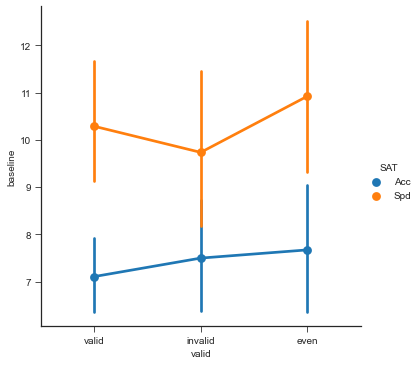

In [110]:
sns.factorplot(x="valid", y='baseline', hue="SAT", data=averages.reset_index())

In [11]:
sns.factorplot(x="valid", y='slope', hue="SAT", data=averages)

NameError: name 'averages' is not defined

In [10]:
1e5

100000.0

<AxesSubplot:xlabel='baseline', ylabel='Density'>

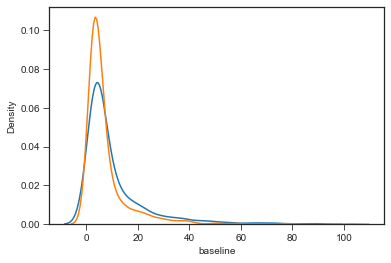

In [90]:
sns.kdeplot(averages[averages.SAT == "Spd"].baseline)
sns.kdeplot(averages[averages.SAT == "Acc"].baseline)

<AxesSubplot:xlabel='slope', ylabel='Density'>

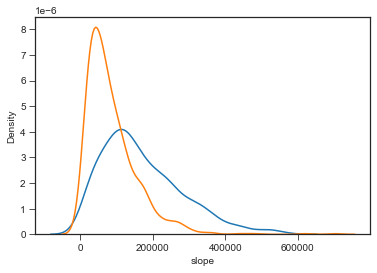

In [109]:
sns.kdeplot(averages[averages.SAT == "Spd"].slope)
sns.kdeplot(averages[averages.SAT == "Acc"].slope)

<AxesSubplot:xlabel='baseline', ylabel='Density'>

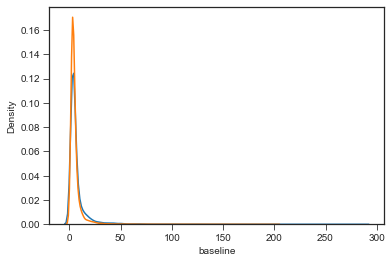

In [9]:
sns.kdeplot(df_EMG_parameters[df_EMG_parameters.SAT == "speed"].baseline)
sns.kdeplot(df_EMG_parameters[df_EMG_parameters.SAT == "accuracy"].baseline)

<AxesSubplot:>

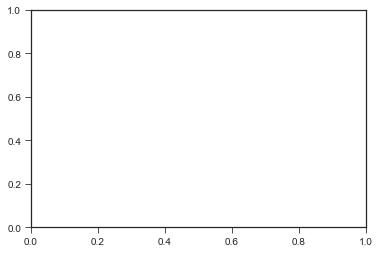

In [12]:
sns.kdeplot(df_EMG_parameters[df_EMG_parameters.SAT == "Spd"].slope)
sns.kdeplot(df_EMG_parameters[df_EMG_parameters.SAT == "Acc"].slope)

<AxesSubplot:xlabel='slope', ylabel='Density'>

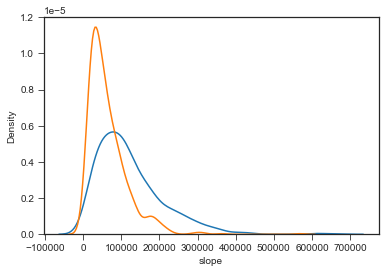

In [91]:
sns.kdeplot(averages[averages.SAT == "Spd"].slope)
sns.kdeplot(averages[averages.SAT == "Acc"].slope)

In [13]:
1.5e6

1500000.0

In [19]:
df_EMG_parameters.slope.mean()

71625.75193851162

In [20]:
8e4

80000.0

In [18]:
1e5

100000.0